## Import Libaries

In [2]:
import glob
from tqdm import tqdm
import datetime
import re
import pandas as pd
import seaborn as sns
import warnings
import os
import pickle
import numpy as np
import utils as ut
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.patches as mpatches
import matplotlib
from scipy import stats
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter, MaxNLocator
import PA_Utils as pa_ut
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from matplotlib.lines import Line2D
from IPython.display import display, Javascript
import matplotlib.patches as patches
from joblib import Parallel, delayed
from scipy.stats import binomtest
import matplotlib.lines as mlines
import io

## Functions

In [3]:
def get_animal_data(data_path, Animal_ID, protocol, data_type):
    """
    Args:
        data_path (str): path to the data folder
        Animal_ID (str): animal ID
        protocol (str): protocol name
        data_type (str): data type (e.g. 'Trial_Summary', 'Detected_Licks')
    Returns:
        animal_df (pd.DataFrame): dataframe containing all the data for the animal
    """

    subject_folders = glob.glob(data_path + Animal_ID +'/*') 
    protocol_folders = list(filter(lambda x: protocol + '_' + Animal_ID in x, subject_folders)) 

    if len(protocol_folders) == 0:
        warnings.warn(f"{Animal_ID}: all_folders empty")
        return 0

    sessions_data = []
    for folder in tqdm(protocol_folders, position=0, leave=True, desc = 'Processing ' + Animal_ID ):  
        folder_files = glob.glob(folder +'/**/'+data_type +'*.csv', recursive = True)
        for file in folder_files:
            try:
                session_df = pd.read_csv(file)
                date_pattern = r'\d{4}_\d{1,2}_\d{1,2}'
                date = re.search(date_pattern, file).group(0)
                date_obj = datetime.datetime.strptime(date, '%Y_%m_%d')
                formatted_date = date_obj.strftime('%Y/%m/%d')
                session_df.insert(0, 'Date', formatted_date)
                session_df['File_ID'] = file  # Add file identifier
                sessions_data.append(session_df)
            except pd.errors.EmptyDataError:
                pass

        animal_df = pd.concat(sessions_data, axis=0, ignore_index=True)
        # Create a list of columns for sorting
        sort_columns = ['Date']

        # Check which of the columns ('Trial_End_Time' or 'Time') exists in the DataFrame
        if 'Trial_End_Time' in animal_df.columns:
            sort_columns.append('Trial_End_Time')
        elif 'Time' in animal_df.columns:
            sort_columns.append('Time')

        # Sort the DataFrame by the determined columns
        animal_df = animal_df.sort_values(by=sort_columns)

        date_list = []
        for date in animal_df.Date.unique():
            date_df = animal_df[animal_df.Date == date].reset_index(drop=True)
            date_list.append(date_df)
            
        animal_df = pd.concat(date_list, axis=0, ignore_index=True)

    return animal_df

def compute_p_stay(sub_df):
    '''
    Compute the probability of staying given reward and no reward
    Args:
        sub_df (pd.DataFrame): The dataframe containing the relevant columns
    Returns:
        p_stay (float): The probability of staying
        p_stay_given_reward (float): The probability of staying given reward
        p_stay_given_no_reward (float): The probability of staying given no reward
    '''
    # calculate p_stay independent of reward
    p_stay = (sub_df['choice'] == sub_df['choice_1']).mean()
    
    # Given reward
    reward_df = sub_df[sub_df['correct_1'] == 1]
    p_stay_given_reward = (reward_df['choice'] == reward_df['choice_1']).mean()

    # No reward
    no_reward_df = sub_df[sub_df['correct_1'] == 0]
    p_stay_given_no_reward = (no_reward_df['choice'] == no_reward_df['choice_1']).mean()

    return p_stay, p_stay_given_reward, p_stay_given_no_reward

def compute_p_switch(sub_df):
    # calculate p_switch independent of reward
    p_switch = (sub_df['choice'] != sub_df['choice_1']).mean()
    
    # Given reward
    reward_df = sub_df[sub_df['correct_1'] == 1]
    p_switch_given_reward = (reward_df['choice'] != reward_df['choice_1']).mean()

    # No reward
    no_reward_df = sub_df[sub_df['correct_1'] == 0]
    p_switch_given_no_reward = (no_reward_df['choice'] != no_reward_df['choice_1']).mean()

    return p_switch, p_switch_given_reward, p_switch_given_no_reward

def add_previous_n_trials_data(group, n=7):
    """
    Add previous n trial data (stim_relative_binned, choice, and correct) to the DataFrame for each participant.
    
    Parameters
    ----------
    group : pd.DataFrame
        The data for a single participant, assumed to have the columns 'Trial', 'No_response',
        'stim_relative_binned', 'choice', and 'correct'.
    n : int
        Number of previous trials to include.
        
    Returns
    -------
    group : pd.DataFrame
        The modified input DataFrame with additional columns for previous trial data
        ('stim_relative_1', 'choice_1', 'correct_1', ... up to n).
    """
    for i in range(1, n+1):
        # Shift the stim_relative_binned, choice, and correct columns by i rows to get previous trial data
        group[f'stim_relative_binned_{i}'] = group['stim_relative_binned'].shift(i)
        group[f'stim_relative_{i}'] = group['Stim_Relative'].shift(i)
        group[f'choice_{i}'] = group['choice'].shift(i)
        group[f'correct_{i}'] = group['correct'].shift(i)
        
        # Set the new columns to NaN for the first i trials of each participant
        group.loc[group['Trial'] < i, [f'stim_relative_{i}', f'choice_{i}', f'correct_{i}']] = np.nan
        
        # Set choice_i and correct_i to NaN for trials where the previous trial had no response
        group.loc[group['No_response'].shift(i) == True, [f'choice_{i}', f'correct_{i}']] = np.nan

    return group

def compute_p_switch_given_n_repeats_and_m_rewards(sub_df, n, m):
    '''
    Compute the probability of switching choice given n successive same actions and m rewards in the last n trials
    Args:
        sub_df (pd.DataFrame): The dataframe containing the relevant columns
        n (int): The number of successive same actions
        m (int): The number of rewards in the last n trials
    Returns:
        p_switch (float): The probability of switching choice given n successive same actions and m rewards in the last n trials
    '''
    # Check for n successive same actions and m rewards in the last n trials
    same_action_conditions = [(sub_df['choice_1'] == sub_df[f'choice_{i}']) for i in range(2, n+1)]
    n_successive_actions = np.all(same_action_conditions, axis=0)
    m_rewards = (sub_df[[f'correct_{i}' for i in range(1, n+1)]].sum(axis=1) == m)
    
    # Filter the dataframe based on these conditions
    sequence_df = sub_df[n_successive_actions & m_rewards]

    # If there are no sequences matching the criteria, return nan
    if len(sequence_df) == 0:
        return np.nan
    
    # Calculate the probability of switch given n successive same actions and m rewards
    p_switch = (sequence_df['choice'] != sequence_df['choice_1']).mean()

    return p_switch

def plot_perf_and_bias(df, Animal_List, save_path=None):
    """
    Creates and displays a plot showing performance and bias for each participant.
    
    :param df: The input dataframe
    :param Animal_List: The list of participant IDs to plot
    :param save_path: The file path to save the resulting plot, if None, plot is not saved
    """
    # Define the number of rows and columns for subplots
    n_rows = 3  # Number of rows
    n_cols = 5  # Number of columns
    filtered_df = df[df.No_response == False]

    # Create subplots with specified number of rows and columns
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 8 * n_rows))
    
    for i, participant_id in enumerate(Animal_List):
        participant_df = filtered_df[filtered_df.Participant_ID == participant_id]
        ax1 = axs.flatten()[i]
        sns.pointplot(data=participant_df, x='Date', y='correct', errorbar=('ci', 95), 
                      ax=ax1, scale=0.5, errwidth=1.5, color='k')
        
        ax1.set_title(f"Participant ID: {participant_id}", fontdict={'fontsize': 12})
        ax1.set_ylim(0, 1)
        # plot bias on a secondary y-axis
        ax2 = ax1.twinx()
        sns.pointplot(data=participant_df, x='Date', y='Choice_Rule_Diff', errorbar=('ci', 95), 
                      ax=ax2, scale=0.5, errwidth=1.5, color='r')
        ax2.set_ylim(-1, 1)
        # change label and tick color
        ax2.tick_params(axis='y', colors='r')
        ax2.set_ylabel('Bias', color='r', rotation=270, labelpad=15)
        # horizontal line at 0.5
        ax1.axhline(y=0.5, color='k', linestyle='--', label='Chance')
        ax1.set_ylabel('Proportion Correct', color='k')
        ax1.set_xlabel('Date', color='k')
        # rotate x-axis labels
        for tick in ax1.get_xticklabels():
            tick.set_rotation(45)
        # only show every 5th x-axis label
        for i, label in enumerate(ax1.xaxis.get_ticklabels()):
            if i % 5 != 0:
                label.set_visible(False)

    # remove empty subplots
    for i in range(len(Animal_List), n_rows * n_cols):
        fig.delaxes(axs.flatten()[i])

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_p_stay(df, Animal_List, save_path = None):
    """
    Creates and displays a plot showing P(Stay), P(Stay/R), and P(Stay/¬R) for each participant.
    
    :param df: The input dataframe
    :param Animal_List: The list of participant IDs to plot
    :param compute_p_stay: The function to compute P(Stay), P(Stay/R), and P(Stay/¬R)
    :param title: The title of the plot, which will be used in the saved filename if save_path is provided
    :param save_dir: The directory to save the resulting plot, if None, plot is not saved
    """
    # Define the number of rows and columns for subplots
    n_rows = 3  # Number of rows
    n_cols = 5  # Number of columns

    # Create subplots with specified number of rows and columns
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 8 * n_rows))

    # Flatten the axs array for easy iteration
    axs = axs.ravel()
    line_colors = {'P(Stay)': 'blue', 'P(Stay/R)': 'magenta', 'P(Stay/¬R)': 'green'}

    for idx, participant in enumerate(Animal_List):
        participant_df = df[df['Participant_ID'] == participant]
        dates = participant_df['Date'].unique()

        # p_stay = []
        p_reward = []
        p_no_reward = []

        for date in dates:
            date_df = participant_df[participant_df['Date'] == date]
            p, p_r, p_nr = compute_p_stay(date_df)
            # p_stay.append(p)
            p_reward.append(p_r)
            p_no_reward.append(p_nr)

        # Plot lines with specified colors from the dictionary
        # axs[idx].plot(dates, p_stay, '-o', label='P(Stay)', color=line_colors['P(Stay)'])
        axs[idx].plot(dates, p_reward, '-o', label='P(Stay/R)', color=line_colors['P(Stay/R)'])
        axs[idx].plot(dates, p_no_reward, '-x', label='P(Stay/¬R)', color=line_colors['P(Stay/¬R)'])
        axs[idx].set_ylim(0, 1)
        axs[idx].axhline(y=0.5, color='k', linestyle='--', label='Chance')
        axs[idx].set_xlabel('Date')
        axs[idx].set_ylabel('Probability')
        axs[idx].set_title(f'Participant {participant}', fontdict={'fontsize': 12})
        axs[idx].legend()
        # rotate the xticks
        axs[idx].tick_params(axis='x', rotation=45)
        # only show every 5th xtick
        for i, label in enumerate(axs[idx].get_xticklabels()):
            if i % 5 != 0:
                label.set_visible(False)

    # Hide any remaining unused subplots
    for j in range(idx + 1, n_rows * n_cols):
        axs[j].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    plt.show()

def plot_psycho_individual(df, Animal_List, save_path=None):
    """
    Plots the psychometric curves for each participant.

    :param df: DataFrame containing the data
    :param Animal_List: List of participant IDs
    :param psycho_fit: Function to fit the psychometric curve, must return a tuple where the first element is the fit parameters
    :param psycho_plot: Function to plot the psychometric curve
    :param save_dir: Directory to save the plot, if None the plot is not saved
    """
    cols = 5
    rows = 2
    fig, axes = plt.subplots(rows, cols, figsize=(cols*8, rows*8))
    axes = axes.ravel()  # Flatten axes for easier indexing
    for i, p_id in enumerate(Animal_List):
        participant_df = df[df['Participant_ID'] == p_id]
        popt = ut.psycho_fit(participant_df)[0]
        ut.psycho_plot(participant_df, popt, label=None, color='k', ax=axes[i], legend=False)        
        axes[i].set_title('Psychometric for ' + p_id, fontdict={'fontsize': 30})
    # remove empty subplots
    for i in range(len(Animal_List), rows * cols):
        fig.delaxes(axes[i])
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def filter_min_rows(df, threshold = 100, iterator = 'Participant_ID', feature = 'block'):
    '''
    For every unique value in the iterator column, remove every 'block' which has less than threshold rows
    Args:
        df (pd.DataFrame): The dataframe to filter
        threshold (int): The minimum number of rows per block
        iterator (str): The column to iterate over
        feature (str): The column to count rows for
    Returns:
        df (pd.DataFrame): The filtered dataframe
    '''
    new_df = pd.DataFrame()
    for pid in df[iterator].unique():
        pid_df = df[df[iterator] == pid]
        new_df = pd.concat([new_df, pid_df.groupby(feature).filter(lambda x: len(x) >= threshold).reset_index(drop=True)])
    return new_df

def add_block_column(df, participant_col, datetime_col, trial_end_time, trial_col):
    # Ensure dataframe is sorted by participant_col and trial_col
    df = df.sort_values(by=[participant_col, datetime_col, trial_end_time])

    # Create a temporary 'block_start' column which is 1 when trial_col is 1 and 0 otherwise
    df['block_start'] = (df[trial_col] == 1).astype(int)

    # For each participant_col, compute the cumulative sum of 'block_start' to get the block number
    df['block'] = df.groupby(participant_col)['block_start'].cumsum()

    # Drop the temporary 'block_start' column
    df = df.drop(columns='block_start')

    return df

def save_notebook():
    '''
    Save the notebook
    '''
    display(Javascript('IPython.notebook.save_checkpoint();'))

## Ignore All FutureWarnings

In [4]:
warnings.simplefilter(action='ignore', category=FutureWarning)

## Set Plotting Parameters

In [5]:
ut.set_plot_font(font_family='sans-serif', title_font_size=14, label_font_size=14, sans_serif_font='Helvetica')

## Fetch Data

In [6]:
data_path = '/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/'
protocol = 'SOUND_CAT'
data_type = 'Trial_Summary'

Animal_List = [
    'QP093', 
    'QP094', 
    'QP096', 
    'QP097', 
    'QP098', 'QP099', 
               'QP0100', 'QP0101', 
               'QP0103',
               'QP0109', 
               'QP0110',
               'QP0122',
               ] 

# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_data_SC.pkl")

# Define the path to the figures
figs_path = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:       
        all_data_SC = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    all_data_SC = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            animal_data = get_animal_data(data_path,
                                             animal, 
                                             protocol,
                                             data_type)
            all_data_SC = pd.concat([all_data_SC, animal_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(all_data_SC, f)

## Process Data


In [7]:
# Processing the data
df = all_data_SC.copy()
df['Datetime'] = pd.to_datetime(df['Date'])
df['Animal_ID'] = pd.Categorical(df['Animal_ID'], categories=Animal_List, ordered=True)

df = add_block_column(df, participant_col='Animal_ID', datetime_col='Datetime', 
                             trial_end_time='Trial_End_Time', trial_col='Trial_Number')

df = df.assign(
    Correct=lambda x: (x['Trial_Outcome'] == 'Correct').astype(int),
    Incorrect=lambda x: (x['Trial_Outcome'] == 'Incorrect').astype(int),
    No_Response=lambda x: (x['Trial_Outcome'] == 'Abort').astype(int),
    choice=lambda x: (x['First_Lick'] == 'Right').astype(int),
    block=lambda x: x['block'] - 1,
    Trial_Number=lambda x: x['Trial_Number'] - 1
)

df.rename(columns={
    'Animal_ID': 'Participant_ID', 
    'Trial_Number': 'Trial',
    'Correct': 'correct',
    'Abort_Trial': 'No_response'
}, inplace=True)

df['Rule_Right'] = (df['Stim_Relative'] > 0).astype(int)
df['Choice_Rule_Diff'] = df['choice'] - df['Rule_Right']

no_response_mask = df['No_response'] == 1
df.loc[no_response_mask, ['correct', 'choice', 'Response_Latency', 'Choice_Rule_Diff']] = np.nan

bins = [-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0]
labels = [-0.875, -0.625, -0.375, -0.125, 0.125, 0.375, 0.625, 0.875]

df['stim_relative_binned'] = pd.cut(
    df['Stim_Relative'], bins=bins, labels=labels, right=False, include_lowest=True
).astype(float)
df.reset_index(drop=True, inplace=True)

In [8]:
# Break Execution at this cell
raise Exception('Break Execution')

Exception: Break Execution

## Performance and Bias

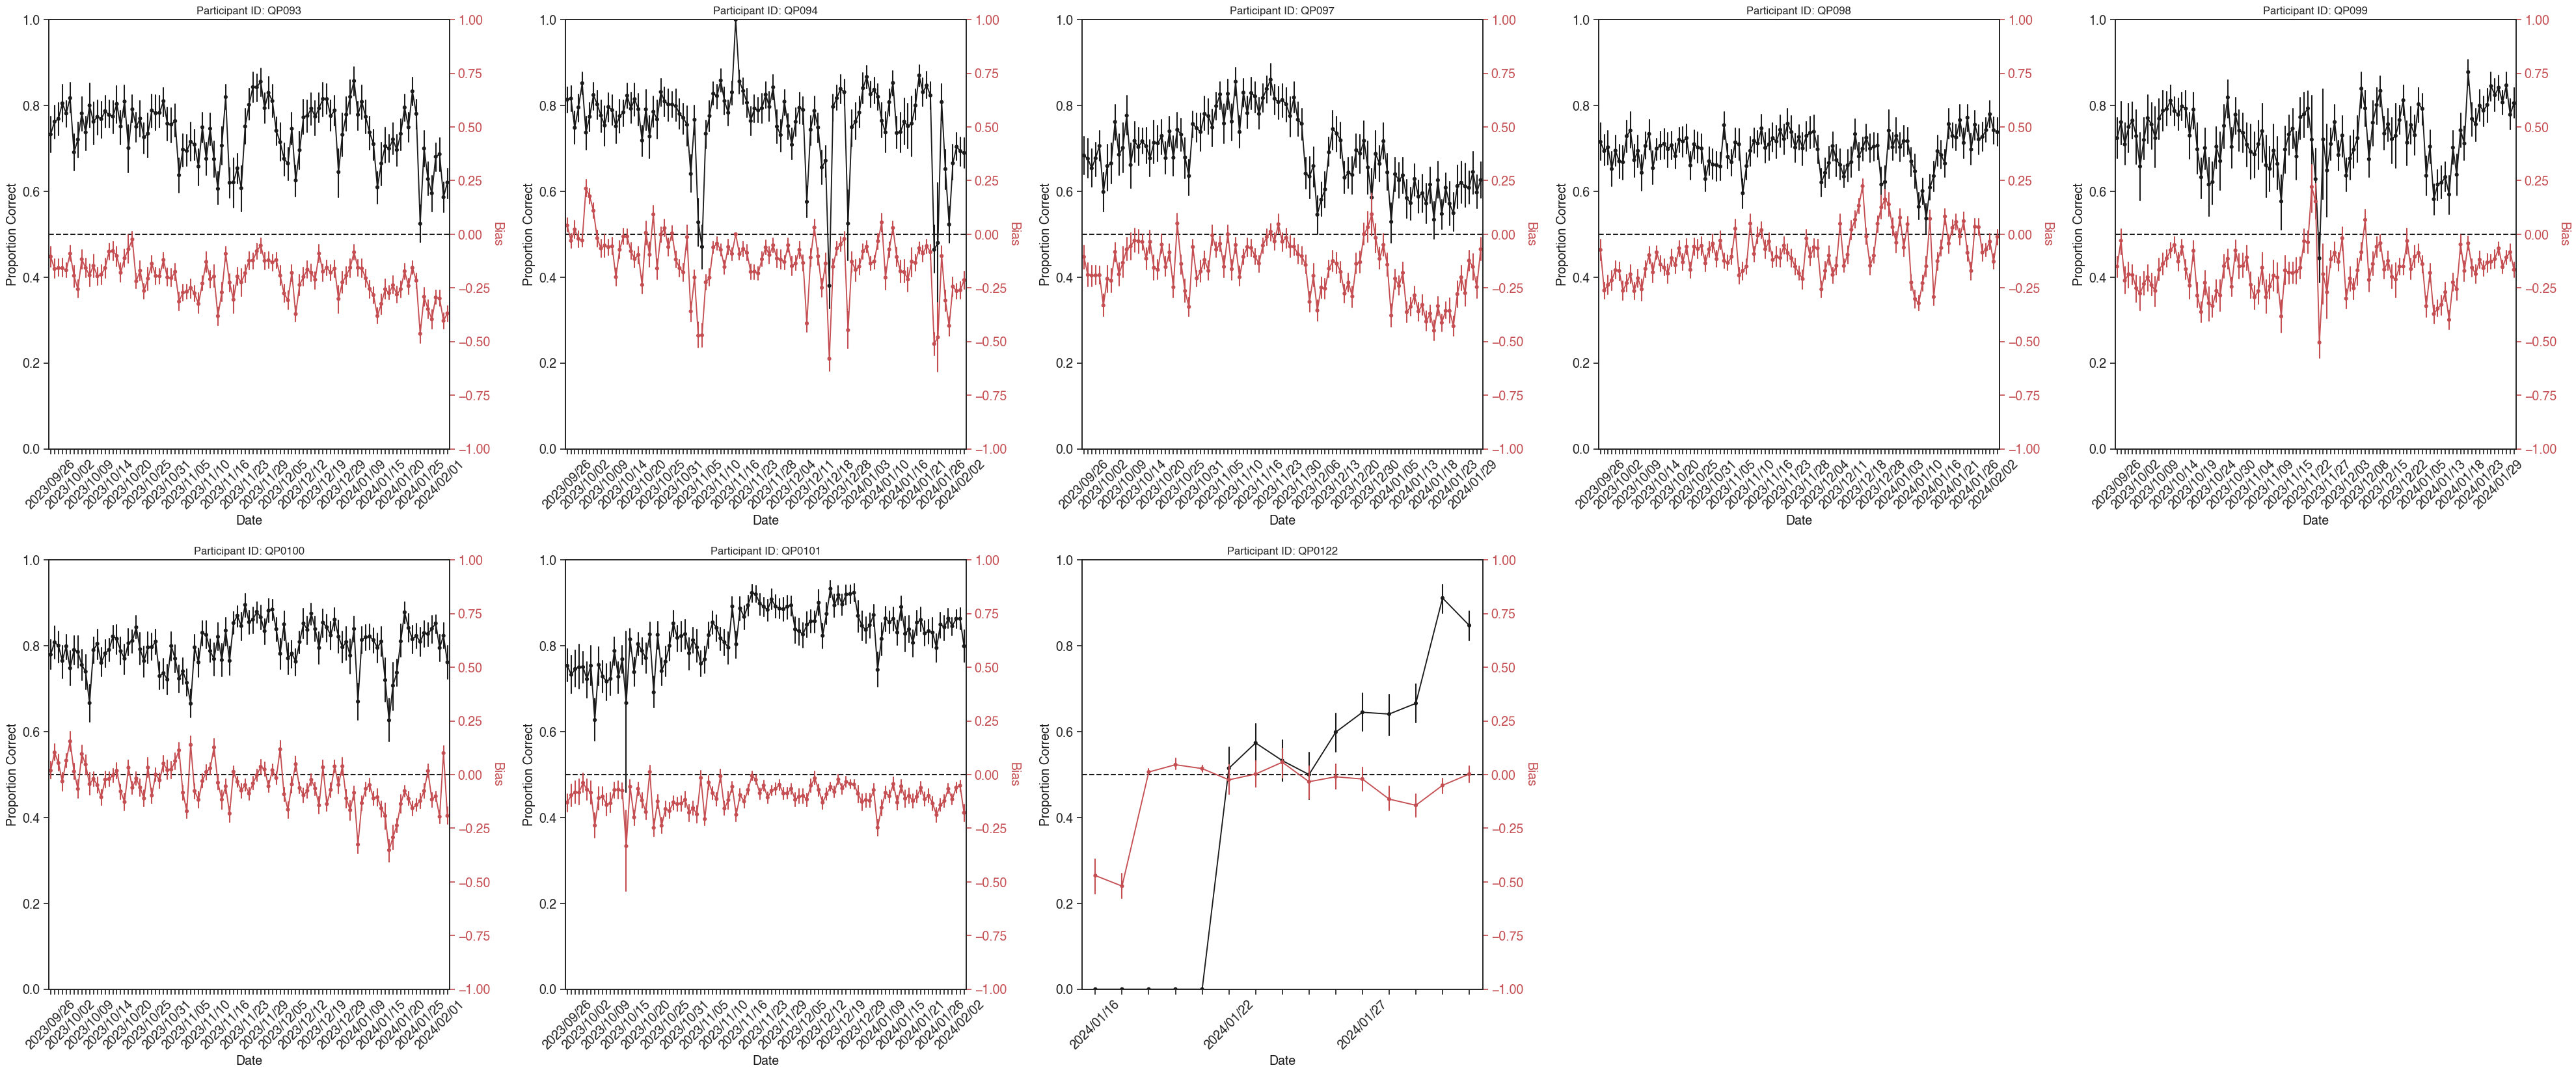

In [ ]:
plot_perf_and_bias(df, Animal_List, save_path= figs_path + 'ACC_PPC_Performance_And_Bias.pdf')

## Choice scatter plots

In [ ]:
for p_id in Animal_List:
    ut.plot_choice_scatter_V2(df = df, p_id= p_id, save_path = figs_path + p_id + '_Choice_Scatter.pdf', show_plot=False,
                              plot_P_Right= True, jitter= 0.025)

## P(Stay/R) and P(Stay/¬R)

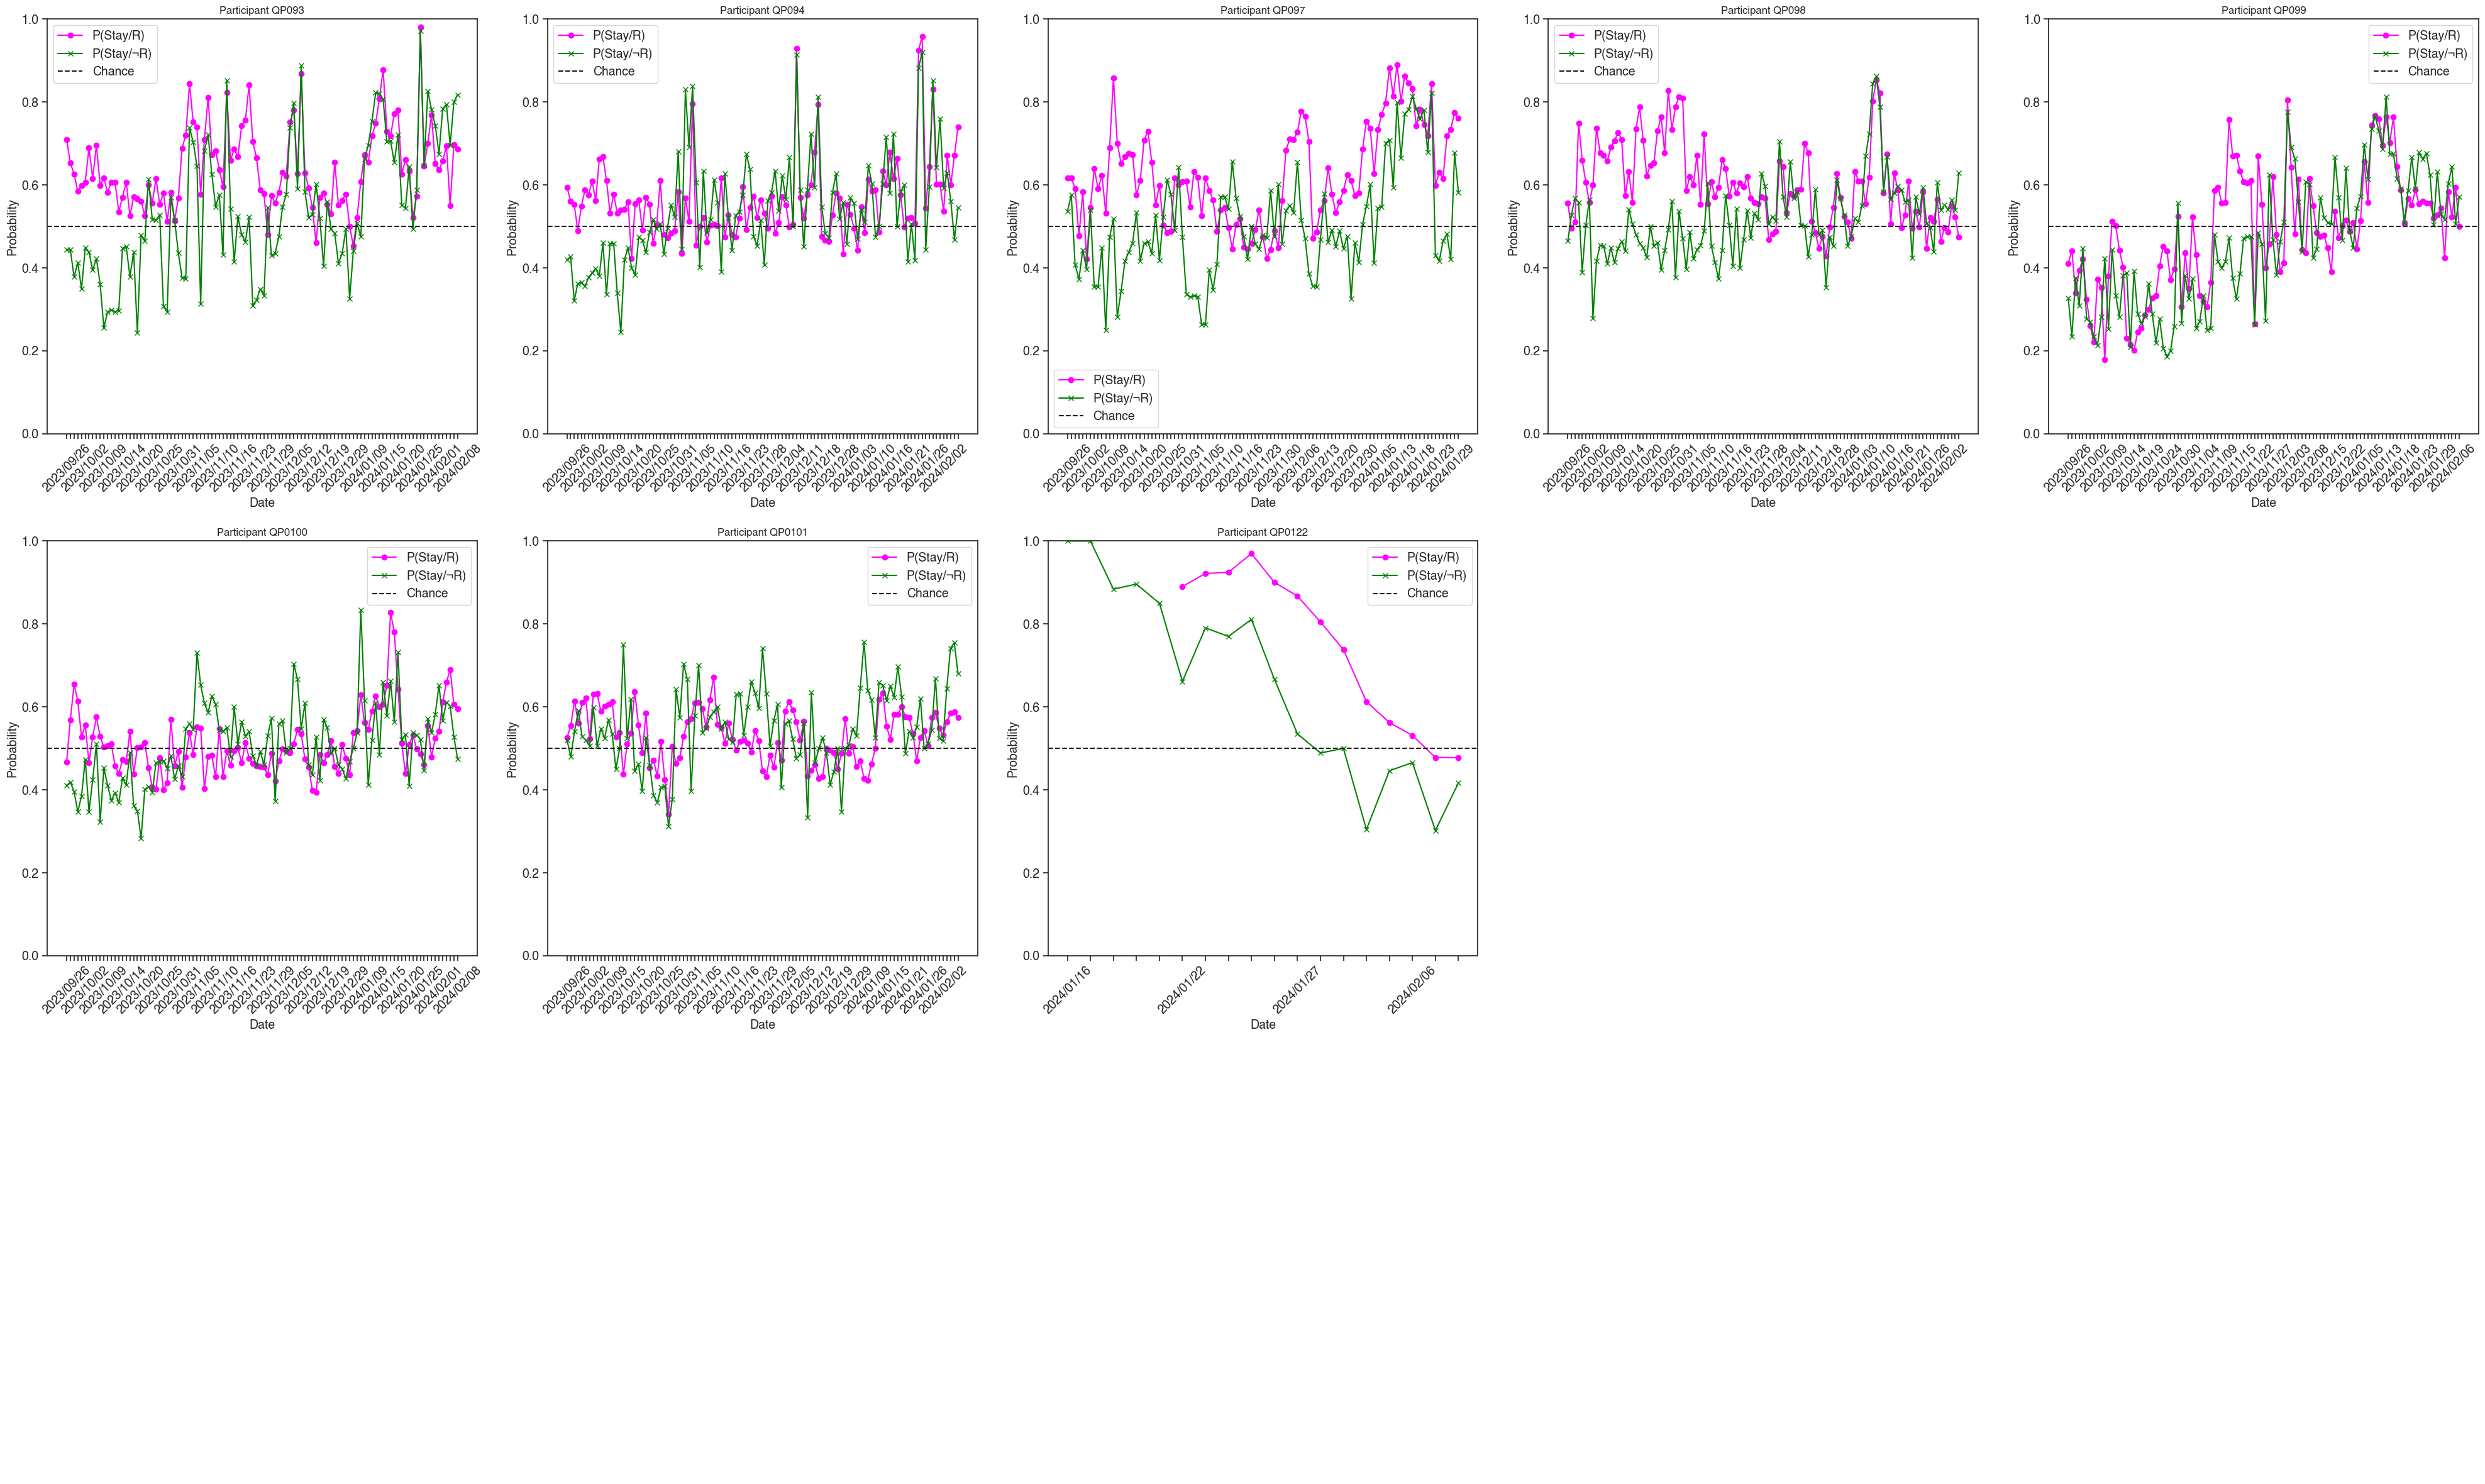

In [ ]:
df = df.groupby('Participant_ID').apply(add_previous_n_trials_data)
df = df.groupby('Participant_ID', group_keys= False).apply(add_previous_n_trials_data)
plot_p_stay(df, Animal_List, save_path= figs_path + 'ACC_PPC_PStay.pdf')

## Psychometric Curves

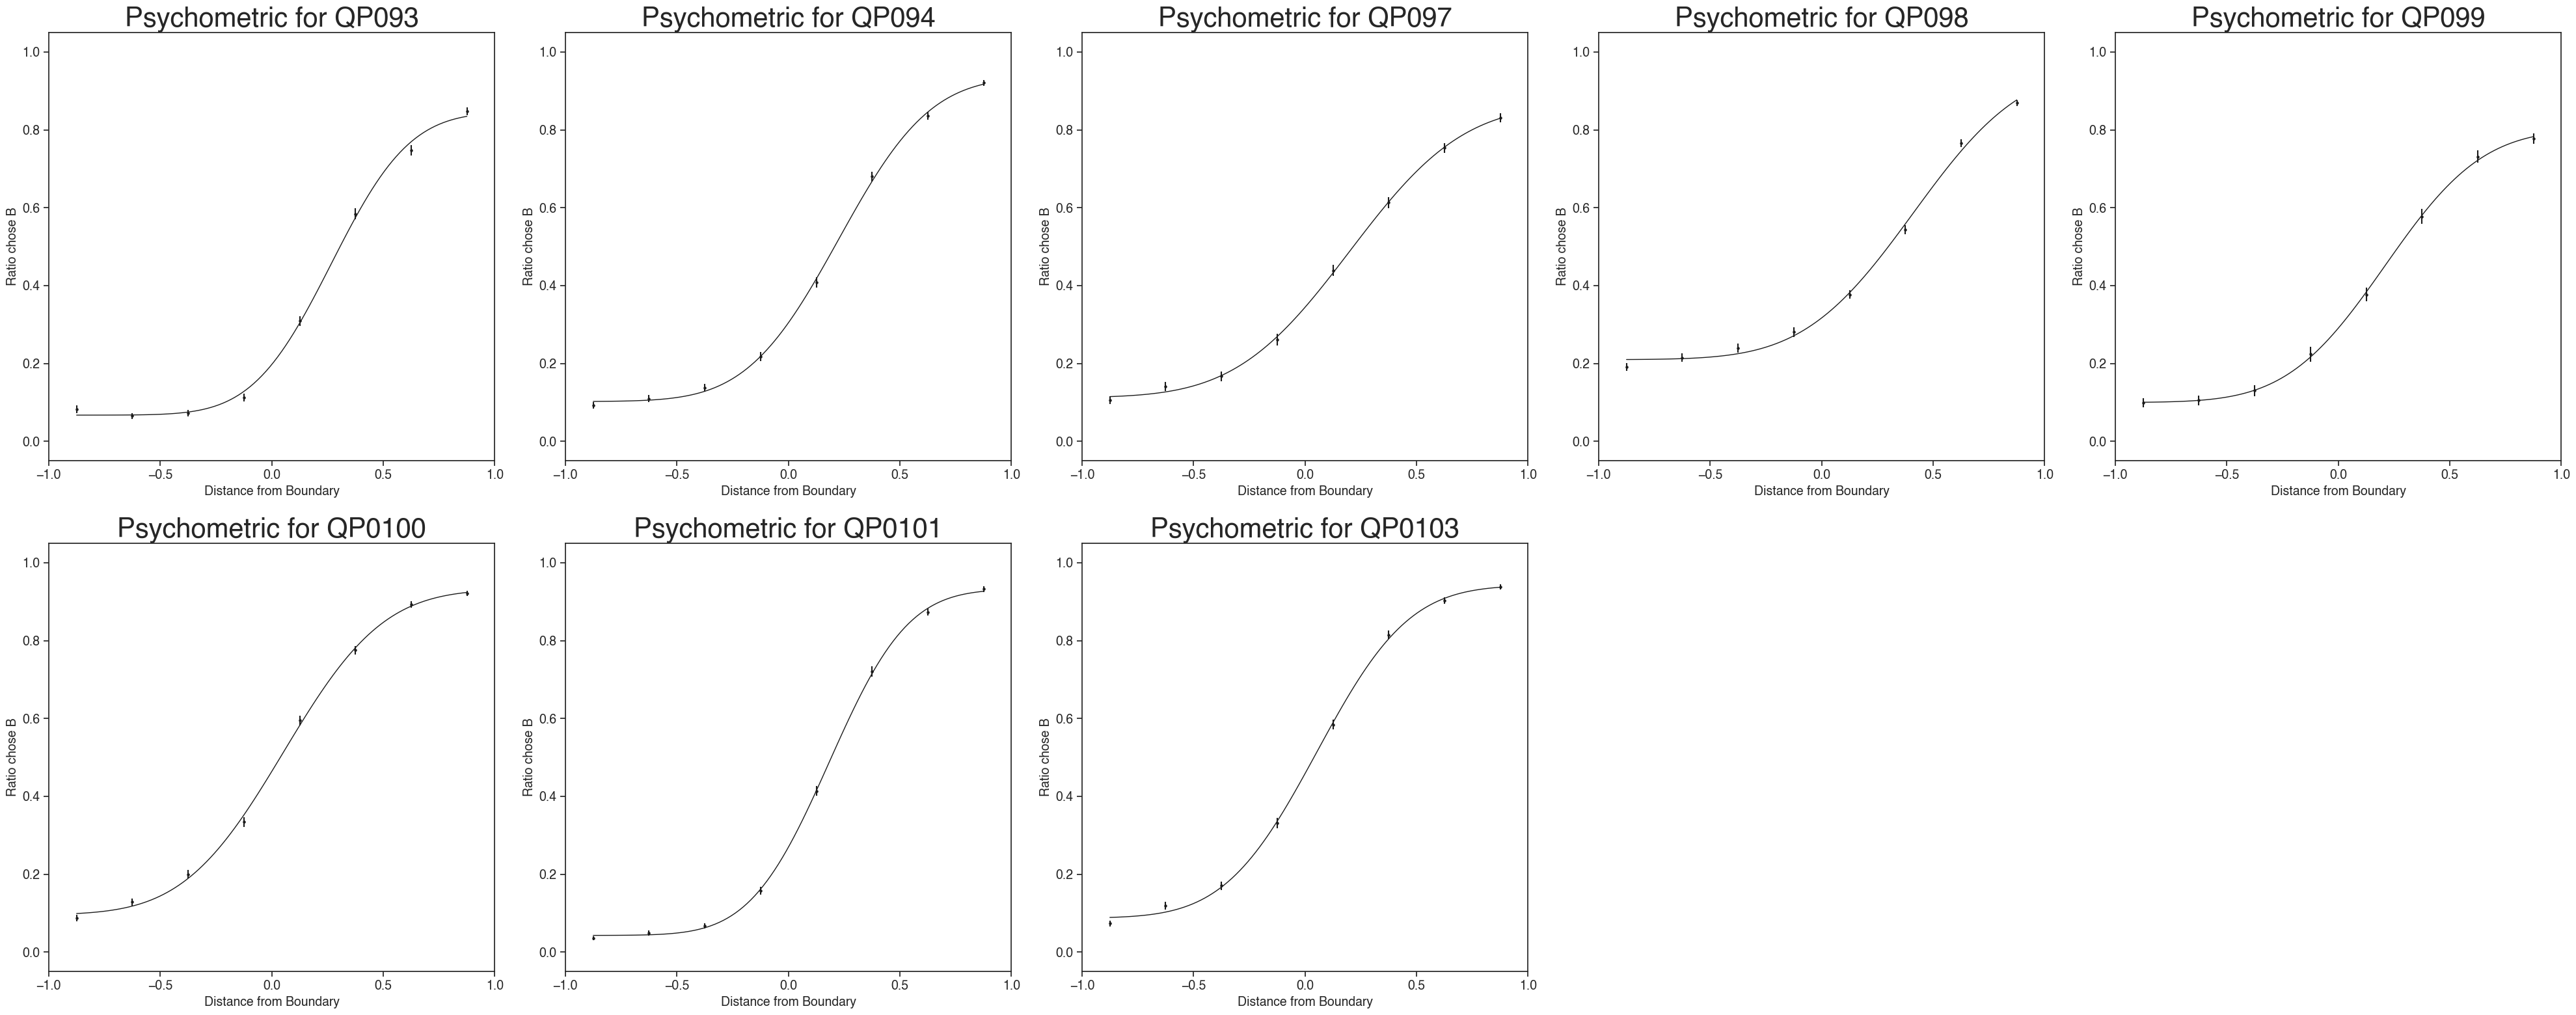

In [ ]:
plot_psycho_individual(df, Animal_List, save_path= figs_path + 'ACC_PPC_Psychometrics.pdf')

### Most Recent Session

/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


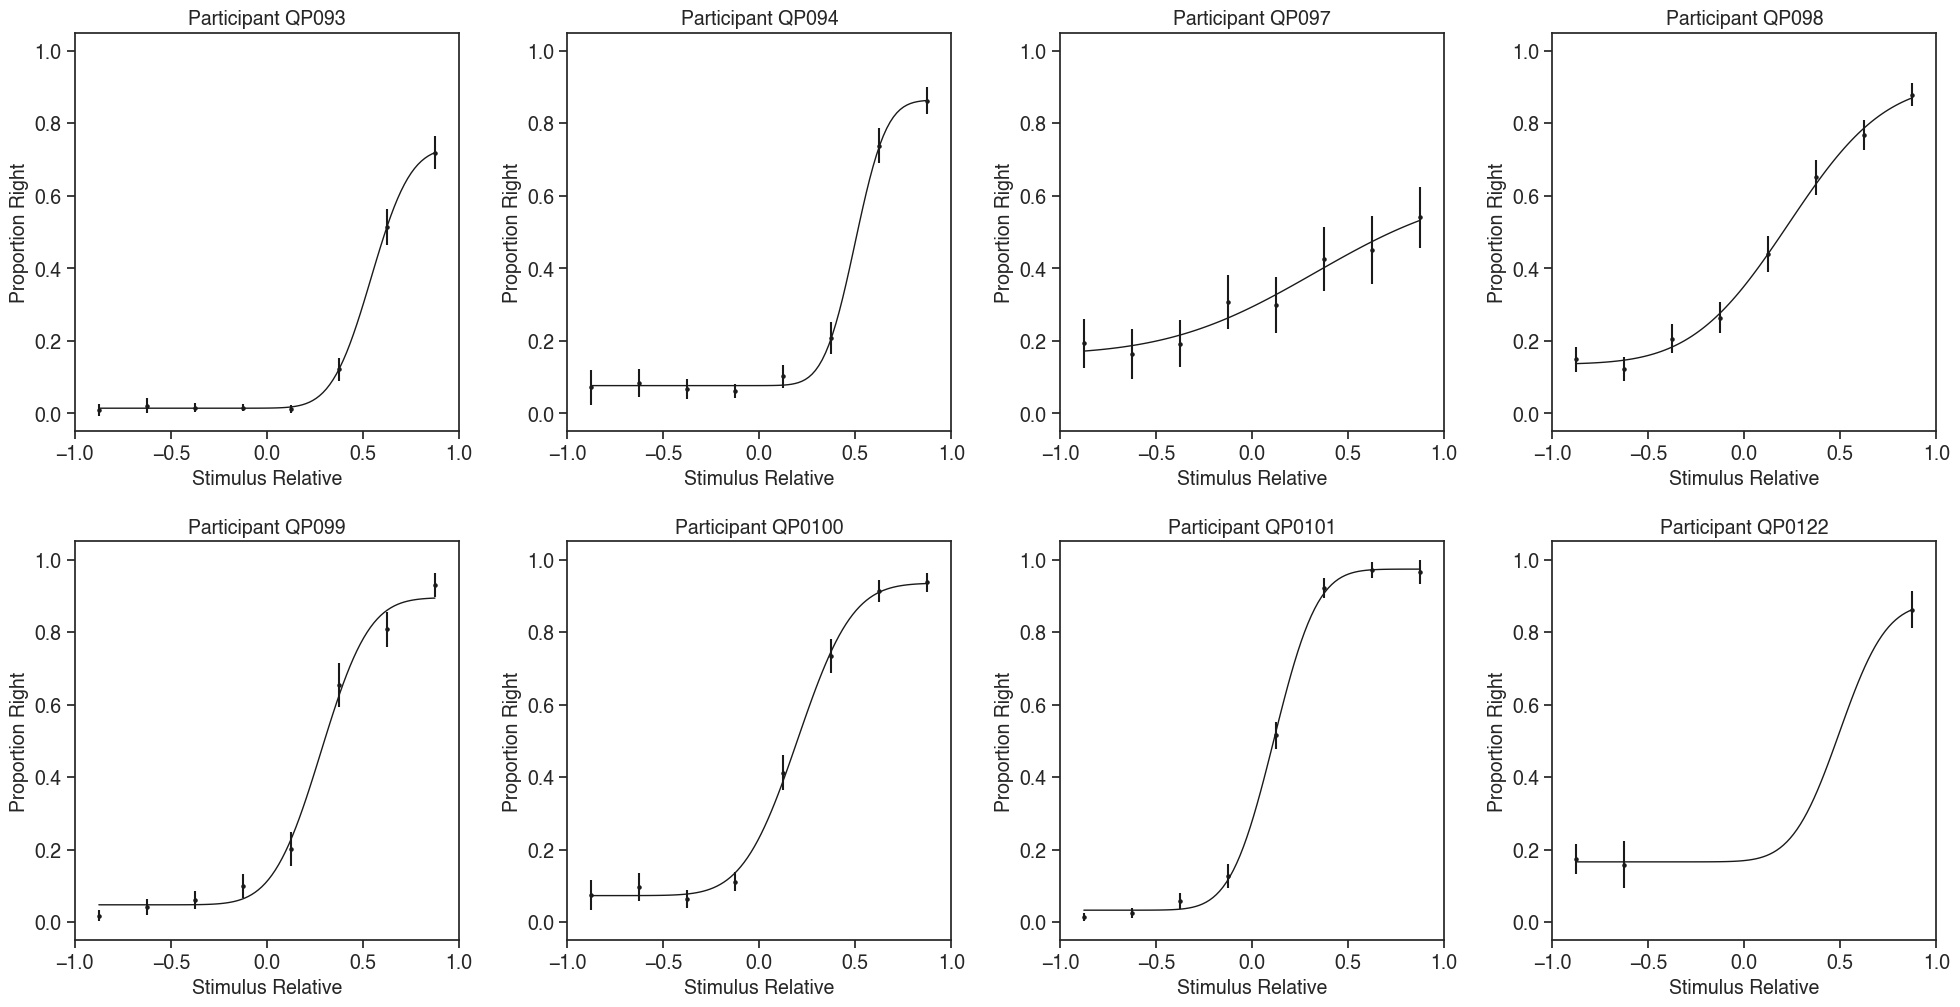

In [ ]:
# date = '2023/11/30'
dates = [
    '2024/01/31',
    '2024/02/01',
    '2024/02/02',
    '2024/02/03',
    '2024/02/04',
    '2024/02/05',
    '2024/02/06',
]

# date_df = df[df['Date'] == date]
date_df = df[df['Date'].isin(dates)]
date_df = date_df[date_df['No_response'] == False].reset_index(drop=True)

fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for i, p_id in enumerate(Animal_List):
    axes[i // 4, i % 4].set_title(f'Participant {p_id}')
    try:
        popt = ut.psycho_fit(date_df[date_df['Participant_ID'] == p_id])[0]
        ut.psycho_plot(date_df[date_df['Participant_ID'] == p_id],  popt, label=None, color='k', ax=axes[i // 4, i % 4], legend=False)
        axes[i // 4, i % 4].set_ylim(-0.05, 1.05)
        axes[i // 4, i % 4].set_xlabel('Stimulus Relative')
        axes[i // 4, i % 4].set_ylabel('Proportion Right')
    except:
        print(f'Participant {p_id} failed to fit')

for i in range(len(Animal_List), 12):
    fig.delaxes(axes[i // 4, i % 4])

plt.tight_layout()
# plt.savefig(figs_path + 'ACC_PPC_Psychometrics_2023_11_29.pdf', dpi=300, bbox_inches='tight')
plt.show()

### 1 subject - last 5 sessions

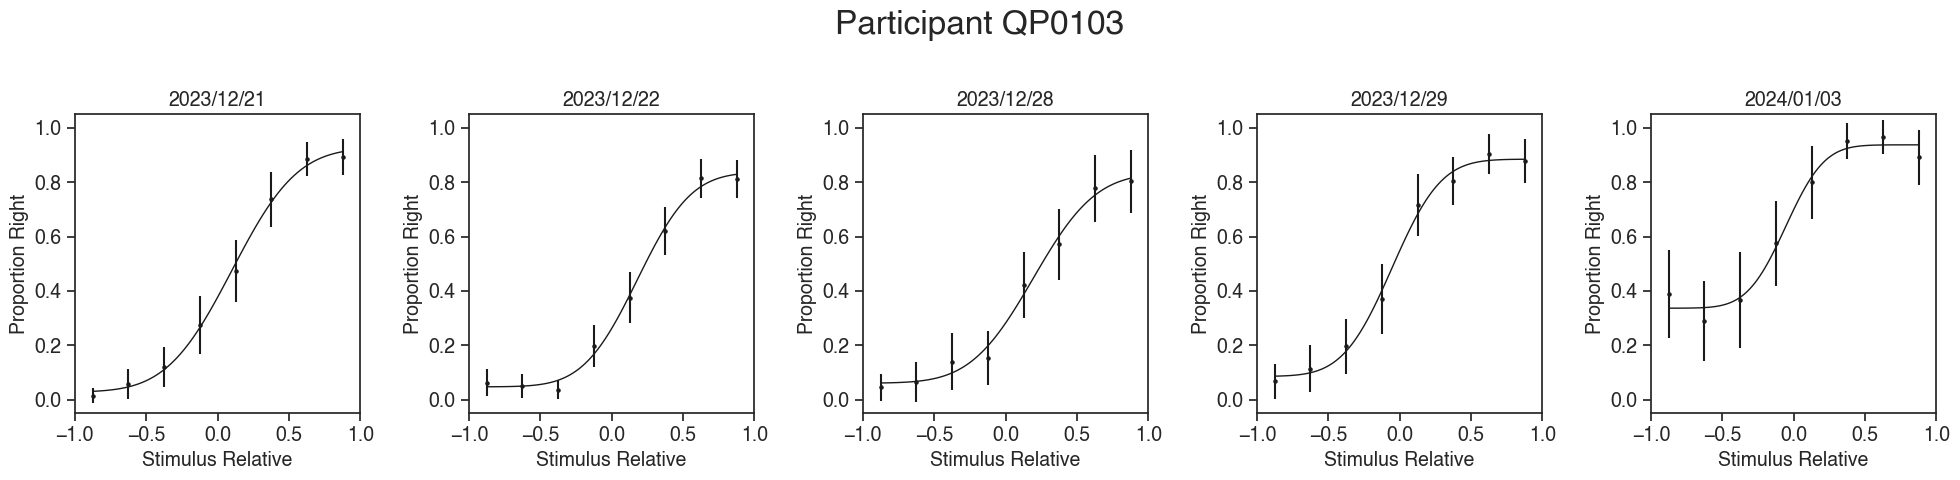

In [ ]:
p_id = 'QP0103'
participant_df = df[df['Participant_ID'] == p_id]
participant_df = participant_df[participant_df['No_response'] == False].reset_index(drop=True)
# grab the last 5 dates
n_back = 5
dates = participant_df['Date'].unique()[-n_back:]

participant_df = participant_df[participant_df['Date'].isin(dates)].reset_index(drop=True)

fig, axes = plt.subplots(1, n_back, figsize=(n_back * 4, n_back))

for i, date in enumerate(dates):
    axes[i].set_title(date)
    popt = ut.psycho_fit(participant_df[participant_df['Date'] == date])[0]
    ut.psycho_plot(participant_df[participant_df['Date'] == date], popt, label=None, color='k', ax=axes[i], legend=False)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].set_xlabel('Stimulus Relative')
    axes[i].set_ylabel('Proportion Right')

plt.suptitle(f'Participant {p_id}')
plt.tight_layout()
# plt.savefig(figs_path + 'ACC_PPC_Psychometrics_QP093.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Single participant analysis

In [ ]:
# write a functions that return the proportion of rows that are Stim_Relative < 0 and Stim_Relative > 0
def get_prop_stim_rel(participant_df, stim_rel = 'Stim_Relative'):
    '''
    Get the proportion of rows that are Stim_Relative < 0 and Stim_Relative > 0
    Args:
        participant_df (pd.DataFrame): The dataframe to filter
        stim_rel (str): The column to filter on
    Returns:
        less_then_zero (float): The proportion of rows that are Stim_Relative < 0
        greater_then_zero (float): The proportion of rows that are Stim_Relative > 0
    '''

    less_then_zero = (participant_df[stim_rel] < 0).sum() / len(participant_df)
    greater_then_zero = (participant_df[stim_rel] > 0).sum() / len(participant_df)
    
    return less_then_zero, greater_then_zero

def run_binomial_test(df, p=0.5, alternative='two-sided', stim_rel = 'Stim_Relative'):
    '''
    Run a binomial test to check if the balance of trials presented on the left and right side is significantly different from 50/50
    Args:
        df (pd.DataFrame): The dataframe to filter
        p (float): The proportion of trials to test against
        alternative (str): The alternative hypothesis, either 'two-sided', 'greater', or 'less'
        stim_rel (str): The column to filter on
    Returns:
        p_value (float): The p-value of the binomial test
    '''

    # get number of trials presented on the left in block_df
    left_trials = df[df[stim_rel] < 0].shape[0]
    # get total number of trials in block_df
    total_trials = df.shape[0]
    result = binomtest(left_trials, total_trials, p=p, alternative=alternative)
    p_value = round(result.pvalue, 5)
    return p_value

In [ ]:
p_id = 'QP0100'
save_path = figs_path + p_id + '_Choice_Behavior.pdf'

# Color dictionary for plots
color_dict = {'prop_correct': 'green', 'prop_incorrect': 'red', 'prop_no_response': 'k'}
step_size = 0.25
min_value = -0.875
# Function to calculate y-axis position for a given value
def calculate_y_position(value):
    return (value - min_value) / step_size
# Calculate y-axis positions for -1, 0, and 1
y_positions = [calculate_y_position(v) for v in [-1, 0, 1]]

participant_df = df[df['Participant_ID'] == p_id]

In [ ]:
for p_id in Animal_List:
    print(f'Processing participant {p_id}')
# for p_id in p_ids:
    save_path = figs_path + p_id + '_Choice_Behavior.pdf'
    participant_df = df[df['Participant_ID'] == p_id]
    with PdfPages(save_path) as pdf:

        # for block in participant_df['block'].unique():
        # only select last 5 blocks
        for block in participant_df['block'].unique()[-10:]:

            # Create a figure with two rows for the two sets of plots
            fig, axs = plt.subplots(2, 2, figsize=(22, 14), gridspec_kw={'width_ratios': [3, 1]}) 

            block_df = participant_df[participant_df['block'] == block]
            block_df = block_df.reset_index(drop=True)
            binomial_p_value = run_binomial_test(block_df, p=0.5, alternative='two-sided', stim_rel = 'Stim_Relative')
            if binomial_p_value > 0.05:
                L_R_ratio = 'Balanced'
            else:
                L_R_ratio = 'Unbalanced'
            
            ax1 = axs[0, 0]
            ax2 = axs[0, 1]

            correct_mask = block_df['correct'] == 1
            incorrect_mask = block_df['Incorrect'] == 1
            no_response_mask = block_df['No_response'] == 1

            ax1.scatter(block_df[correct_mask]['Trial'], block_df[correct_mask]['stim_relative_binned'], 
                        color='green', marker='o', label='Correct', alpha=0.5)
            ax1.scatter(block_df[incorrect_mask]['Trial'], block_df[incorrect_mask]['stim_relative_binned'], 
                        color='red', marker='^', label='Incorrect', alpha=0.5)
            ax1.scatter(block_df[no_response_mask]['Trial'], block_df[no_response_mask]['stim_relative_binned'], 
                        color='black', marker='x', label='No Response', alpha=0.5)
            ax1.set_yticks([-1, 0, 1])
            ax1.set_yticklabels(['-1', '0', '1'])
            ax1.set_ylim(-1, 1)
            ax1.set_xlabel('Trial')
            ax1.set_ylabel('Distance from Boundary')

            grouped_by_stim_rel = block_df[['stim_relative_binned', 'correct', 'Incorrect', 'No_Response']] \
                                    .groupby('stim_relative_binned').sum()
            grouped_by_stim_rel['total'] = grouped_by_stim_rel.sum(axis=1)
            grouped_by_stim_rel['prop_correct'] = grouped_by_stim_rel['correct'] / grouped_by_stim_rel['total']
            grouped_by_stim_rel['prop_incorrect'] = grouped_by_stim_rel['Incorrect'] / grouped_by_stim_rel['total']
            grouped_by_stim_rel['prop_no_response'] = grouped_by_stim_rel['No_Response'] / grouped_by_stim_rel['total']
            grouped_by_stim_rel = grouped_by_stim_rel[['prop_correct', 'prop_incorrect', 'prop_no_response']] 
            grouped_by_stim_rel.plot(kind='barh', stacked=True, ax=ax2, width=1, color=[color_dict.get(x) for x in grouped_by_stim_rel.columns], alpha=0.5, legend=False)

            below_above_proportions = get_prop_stim_rel(block_df, stim_rel = 'Stim_Relative')

            ax2.set_xlabel('Proportions')
            ax2.set_ylabel(' ')
            ax2.set_xticks(np.arange(0, 1.1, 0.5))
            ax2.set_yticks(y_positions)
            ax2.set_yticklabels([-1, 0, 1], rotation=0)

        # ----------------------- Plot 2 (Row 2) -----------------------
            valid_block_df = block_df[block_df['No_response'] == 0].reset_index(drop=True)

            ax3 = axs[1, 0]
            ax4 = axs[1, 1]

            correct_mask = valid_block_df['correct'] == 1
            incorrect_mask = valid_block_df['Incorrect'] == 1

            ax3.scatter(valid_block_df[correct_mask]['Trial'], valid_block_df[correct_mask]['stim_relative_binned'],
                        color='green', marker='o', label='Correct', alpha=0.5)
            ax3.scatter(valid_block_df[incorrect_mask]['Trial'], valid_block_df[incorrect_mask]['stim_relative_binned'],
                        color='red', marker='^', label='Incorrect', alpha=0.5)
            ax3.set_yticks([-1, 0, 1])
            ax3.set_yticklabels(['-1', '0', '1'])
            ax3.set_ylim(-1, 1)
            ax3.set_xlabel('Trial')
            ax3.set_ylabel('Distance from Boundary')

            grouped_by_stim_rel_valid = valid_block_df[['stim_relative_binned', 'correct', 'Incorrect']] \
                                    .groupby('stim_relative_binned').sum()
            grouped_by_stim_rel_valid['total'] = grouped_by_stim_rel_valid.sum(axis=1)
            grouped_by_stim_rel_valid['prop_correct'] = grouped_by_stim_rel_valid['correct'] / grouped_by_stim_rel_valid['total']
            grouped_by_stim_rel_valid['prop_incorrect'] = grouped_by_stim_rel_valid['Incorrect'] / grouped_by_stim_rel_valid['total']
            grouped_by_stim_rel_valid = grouped_by_stim_rel_valid[['prop_correct', 'prop_incorrect']] 
            try:
                grouped_by_stim_rel_valid.plot(kind='barh', stacked=True, ax=ax4, width=1, color=[color_dict.get(x) for x in grouped_by_stim_rel_valid.columns], 
                                            alpha=0.5, legend=False)
            except:
                pass
            
            ax4.set_xlabel('Proportions')
            ax4.set_ylabel(' ')
            ax4.set_xticks(np.arange(0, 1.1, 0.5))
            ax4.set_yticks(y_positions)
            ax4.set_yticklabels([-1, 0, 1], rotation=0)

            params = {
                'Parameter': ['Participant', 'Date', 'Block', 'Distribution', 'AntiBias', 'Prop Stim Rel < 0', 
                              'Prop Stim Rel > 0', 'Left/Right Ratio', 'Opto'],
                'Value': [p_id, block_df['Datetime'].iloc[0].strftime('%Y/%m/%d'), block, block_df['Distribution'].iloc[0], 
                          block_df['Anti_Bias'].iloc[0], round(below_above_proportions[0], 2), round(below_above_proportions[1], 2), 
                          L_R_ratio, block_df['Opto_On'].iloc[0]]
            }
            params_df = pd.DataFrame(params)
            table = ax1.table(cellText=params_df.values, colLabels=params_df.columns, cellLoc = 'center', loc='top', bbox=[0, 1.1, 1, 0.5])
            # Set font to Arial and make headers bold
            for key, cell in table.get_celld().items():
                if key[0] == 0:  # Column headers are in the first row
                    cell.set_fontsize(12)
                    cell.get_text().set_fontname('Arial')
                    cell.get_text().set_weight('bold')

            plt.tight_layout()
            pdf.savefig()
            plt.close()

Processing participant QP093


Processing participant QP094
Processing participant QP097
Processing participant QP098
Processing participant QP099
Processing participant QP0100
Processing participant QP0101
Processing participant QP0122


In [ ]:
# Breakdown execution at this cell
raise Exception('Stop Execution')

Exception: Stop Execution

## Correlation between rule right and chose right

In [ ]:
def get_bias_df(df, p_ids, groupby='Block'):
    '''
    Get a dataframe with p_id, block, prop_went_right, prop_rule_right, and anti_bias
    Args:
        df (pd.DataFrame): The dataframe to filter
        p_ids (list): The list of participant ids
        groupby (str): The column to group by
    Returns:
        bias_df (pd.DataFrame): The dataframe.
    '''
    bias_df = pd.DataFrame(columns=['Participant_ID', 'Block', 'Prop_Went_Right', 'Prop_Rule_Right', 'Psycho_Mean', 'Anti_Bias'])

    for p_id in p_ids:
        participant_df = df[df['Participant_ID'] == p_id]

        bias_list = []
        prop_above_list = []
        antibias_list = []
        block_list = []
        psycho_mean_list = []

        for block in participant_df[groupby].unique():
            block_df = participant_df[participant_df[groupby] == block].reset_index(drop=True)
            _, prop_above = get_prop_stim_rel(block_df, stim_rel='Stim_Relative')
            prop_above_list.append(prop_above)
            
            block_df_valid = block_df[block_df['No_response'] == 0].reset_index(drop=True)
            bias_list.append(block_df_valid['choice'].mean())
            try:
                psycho_mean, _ , _ , _ = ut.psycho_fit(block_df_valid)[0]
            except:
                psycho_mean = np.nan
            psycho_mean_list.append(psycho_mean)
            antibias_list.append(block_df['Anti_Bias'].iloc[0])
            block_list.append(block)

        participant_bias_df = pd.DataFrame({'Participant_ID': p_id, 'Block': block_list, 'Prop_Went_Right': bias_list, 
                                            'Prop_Rule_Right': prop_above_list, 'Anti_Bias': antibias_list, 'Psycho_Mean': psycho_mean_list})
        bias_df = bias_df.append(participant_bias_df, ignore_index=True)   

    return bias_df

def plot_sampling_vs_choice(df, x, y, color_dict, marker_dict, save_path = None):
    '''
    Plot a scatter plot of x vs y for each participant in df
    Args:
        df (pd.DataFrame): The dataframe to filter
        x (str): The column to plot on the x-axis
        y (str): The column to plot on the y-axis
        color_dict (dict): A dictionary mapping a value in df[x] to a color
        marker_dict (dict): A dictionary mapping a value in df['Participant_ID'] to a marker
        save_path (str): The path to save the figure, if None the figure is not saved
    '''
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    for p_id in df['Participant_ID'].unique():
        p_id_df = df[df['Participant_ID'] == p_id]
        colors = p_id_df['Anti_Bias'].map(color_dict).fillna('gray').tolist()

        ax.scatter(p_id_df[x], p_id_df[y], marker=marker_dict[p_id], alpha=0.5, 
                c=colors)  
        ax.set_xlabel('Prop. Rule Right')
        ax.set_ylabel('Prop. Went Right')
        ax.set_ylim(-0.05, 1.05)
        ax.set_xlim(-0.05, 1.05)
    ax.axvline(x=0.4, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=0.6, color='gray', linestyle='--', alpha=0.5)
    legend1_elements = [mlines.Line2D([0], [0], color='red', marker='o', linestyle='None', markersize=10, label='True'),
                        mlines.Line2D([0], [0], color='black', marker='o', linestyle='None', markersize=10, label='False')]
    legend1 = ax.legend(handles=legend1_elements, loc='upper left', title="AntiBias")
    legend2_elements = [mlines.Line2D([0], [0], color='black', marker=marker, linestyle='None', markersize=10, label=pid) 
                        for pid, marker in marker_dict.items()]
    legend2 = ax.legend(handles=legend2_elements, loc='upper right', title="Participant ID", bbox_to_anchor=(1.25, 1))
    ax.add_artist(legend1)
    ax.set_title('Choice Bias Vs Sampling Bias')
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_sampling_scatter(df, x, y, color_dict, marker_dict, x_label, y_label, title, 
                 ylim=(-0.05, 1.05), xlim=(-0.05, 1.05), vlines=None, 
                 save_path=None):
    fig, ax = plt.subplots(figsize=(10, 8))

    for p_id in df['Participant_ID'].unique():
        p_id_df = df[df['Participant_ID'] == p_id]
        colors = p_id_df['Anti_Bias'].map(color_dict).fillna('gray').tolist()

        ax.scatter(p_id_df[x], p_id_df[y], marker=marker_dict[p_id], alpha=0.5, c=colors)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(*ylim)
    ax.set_xlim(*xlim)

    if vlines:
        for vline in vlines:
            ax.axvline(x=vline, color='gray', linestyle='--', alpha=0.5)

    legend1_elements = [mlines.Line2D([0], [0], color='red', marker='o', linestyle='None', markersize=10, label='True'),
                        mlines.Line2D([0], [0], color='black', marker='o', linestyle='None', markersize=10, label='False')]
    legend1 = ax.legend(handles=legend1_elements, loc='upper left', title="AntiBias")
    legend2_elements = [mlines.Line2D([0], [0], color='black', marker=marker, linestyle='None', markersize=10, label=pid) 
                        for pid, marker in marker_dict.items()]
    legend2 = ax.legend(handles=legend2_elements, loc='upper right', title="Participant ID", bbox_to_anchor=(1.25, 1))
    ax.add_artist(legend1)

    ax.set_title(title)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# drop all rows of df where Participant_ID == nan
df = df.dropna(subset=['Participant_ID']).reset_index(drop=True)
# need minimum 100 trials per block
sub_df = filter_min_rows(df, threshold=100, iterator='Participant_ID', feature='block')

In [ ]:
p_ids = sub_df['Participant_ID'].unique()
groupby = 'block'
bias_df = get_bias_df(df = sub_df,
                      p_ids= p_ids,
                      groupby= 'block')

/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3

In [ ]:
color_dict = {True: 'red', False: 'black'}
marker_dict = {'QP093': '^', 'QP094': 'o', 'QP096': 's', 
               'QP097': 'p', 'QP098': 'P', 'QP099': 'X', 
               'QP0100': 'D', 'QP0101': 'd', 'QP0103': 'v', 
               'QP0109': '8', 'QP0110': 'h'}

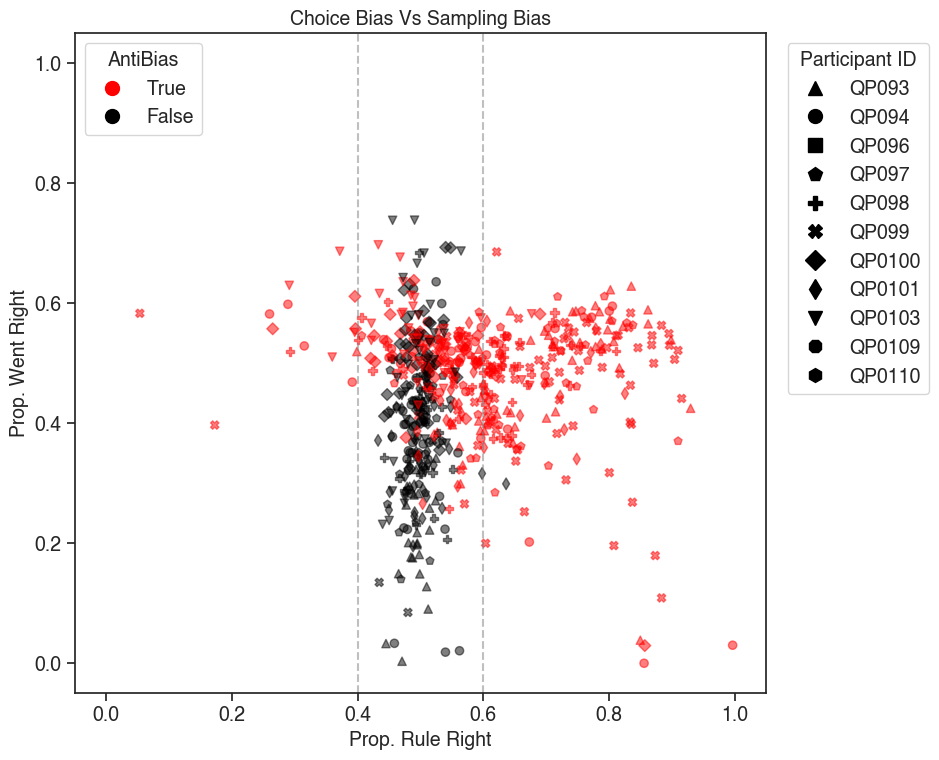

In [ ]:
plot_sampling_scatter(df=bias_df, x='Prop_Rule_Right', y='Prop_Went_Right', color_dict=color_dict, 
             marker_dict=marker_dict, x_label='Prop. Rule Right', y_label='Prop. Went Right', 
             title='Choice Bias Vs Sampling Bias', ylim=(-0.05, 1.05), xlim=(-0.05, 1.05), 
             vlines=[0.4, 0.6], save_path=None)

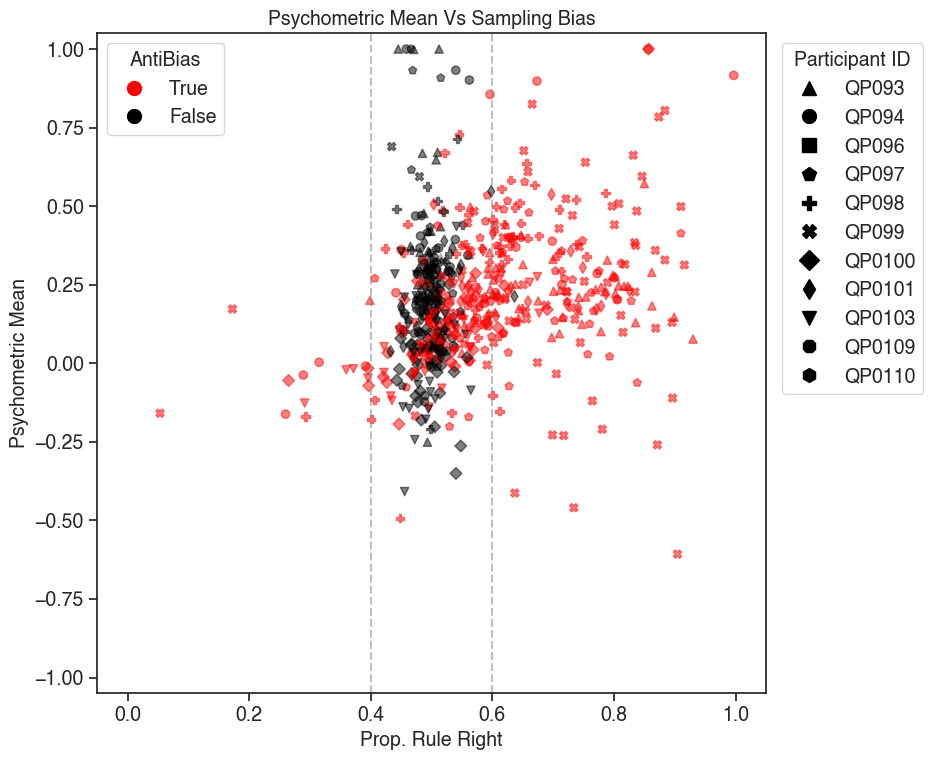

In [ ]:
plot_sampling_scatter(df=bias_df, x='Prop_Rule_Right', y='Psycho_Mean', color_dict=color_dict, 
             marker_dict=marker_dict, x_label='Prop. Rule Right', y_label='Psychometric Mean', 
             title='Psychometric Mean Vs Sampling Bias', ylim=(-1.05, 1.05), xlim=(-0.05, 1.05), 
             vlines=[0.4, 0.6], save_path= figs_path + 'ACC_PPC_Psychometric_Mean_Vs_Sampling_Bias.pdf')

In [ ]:
# break execution at this cell
raise Exception('Stop Execution')

Exception: Stop Execution

In [ ]:
# only keep data after 2023/11/20
sub_df = df[df['Datetime'] > '2023/11/20'].reset_index(drop=True)

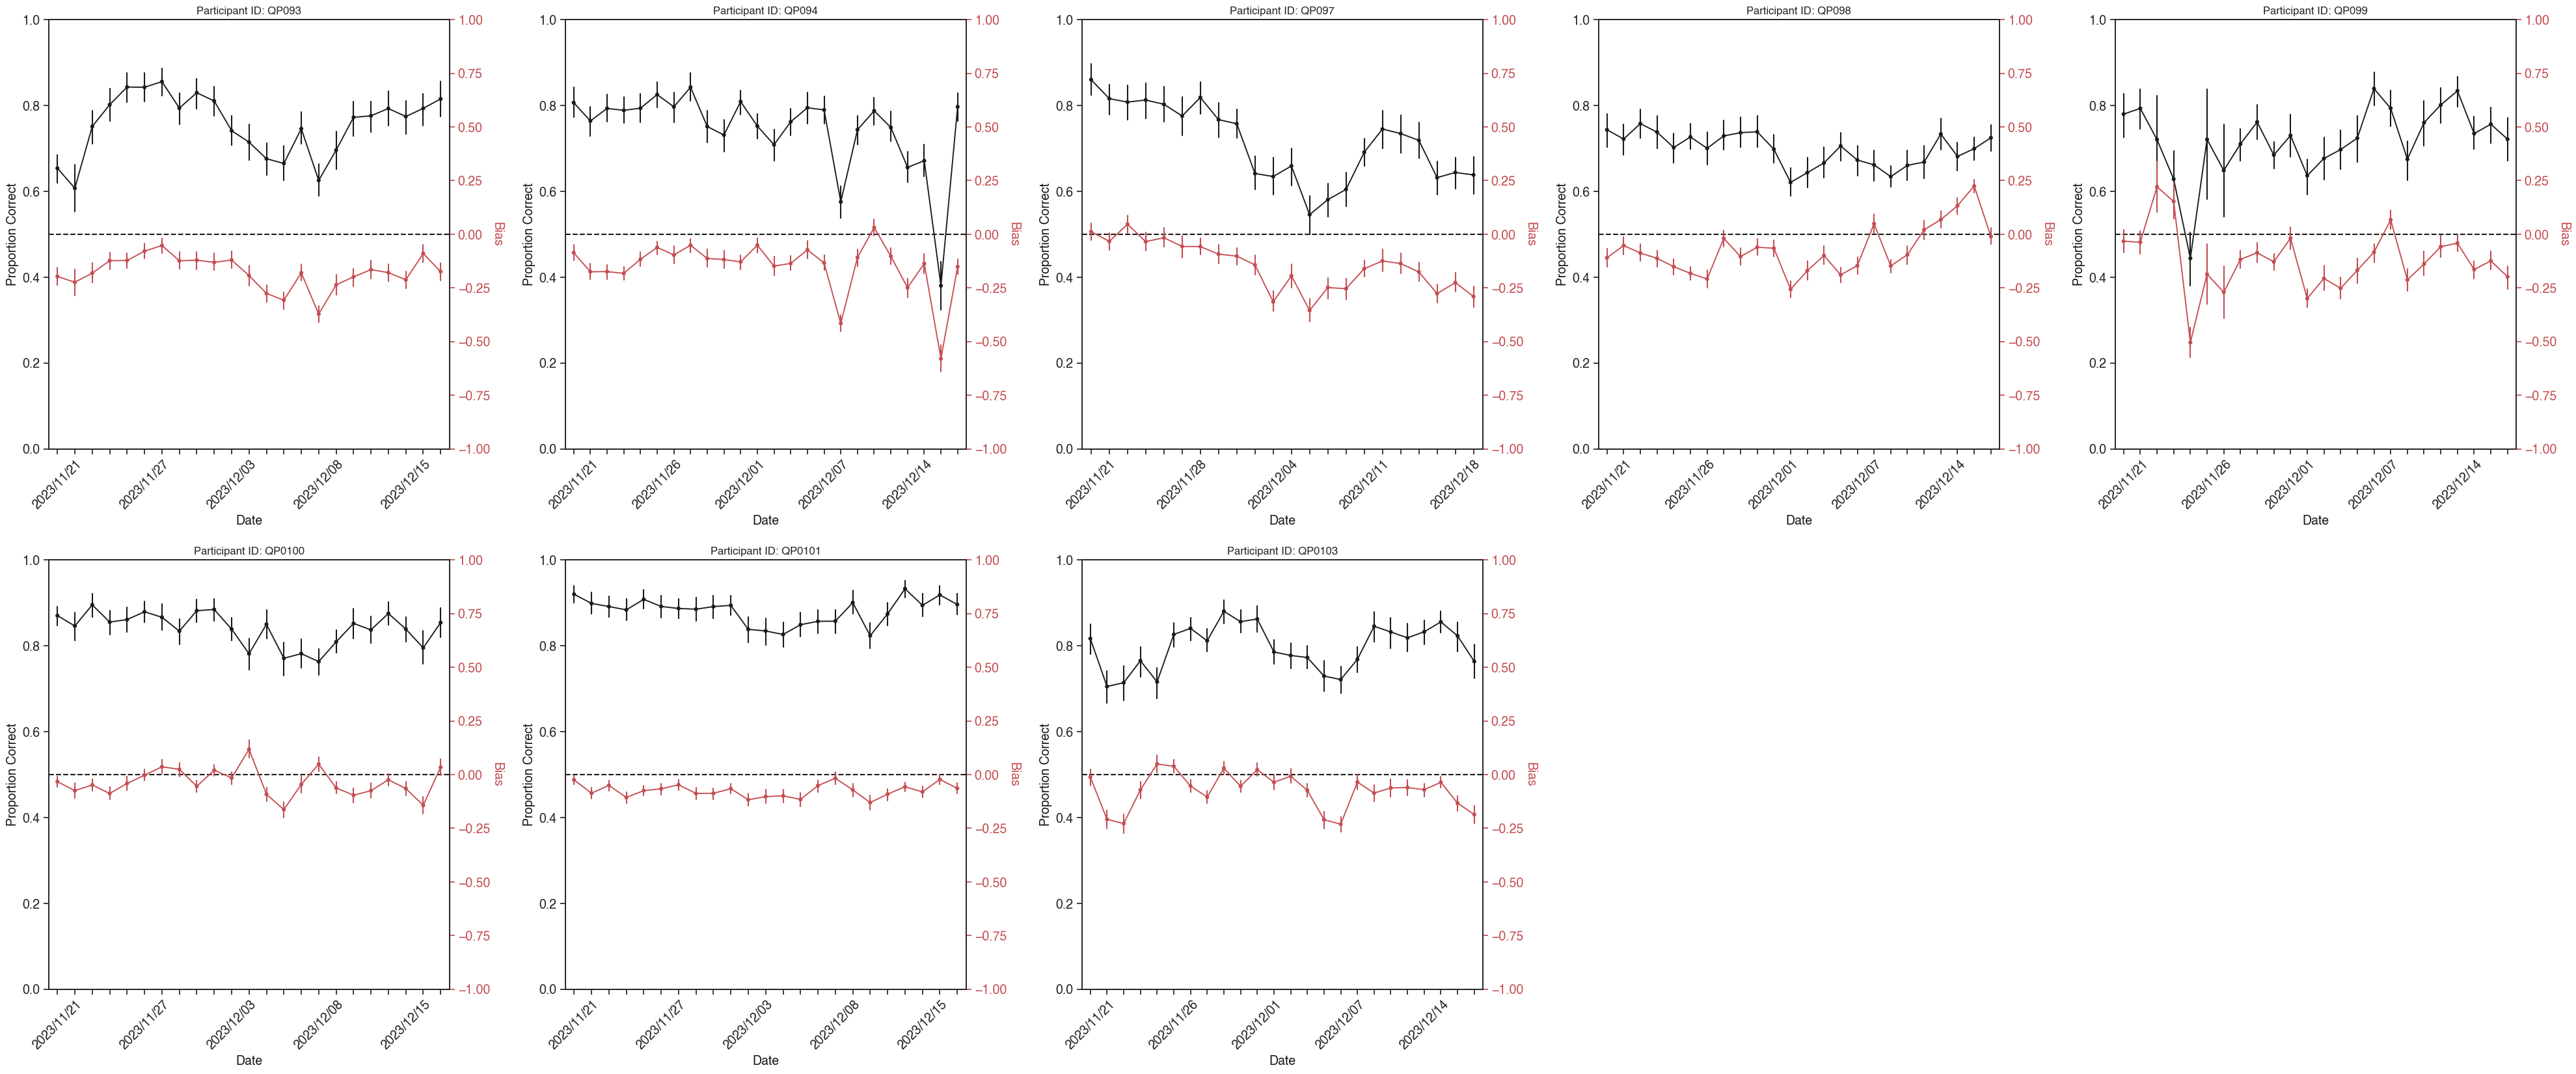

In [ ]:
plot_perf_and_bias(sub_df, Animal_List, save_path= figs_path + 'ACC_PPC_Perf_Bias_After_2023_11_20.pdf')

In [ ]:
sub_df_valid = sub_df[sub_df['No_response'] == 0].reset_index(drop=True)

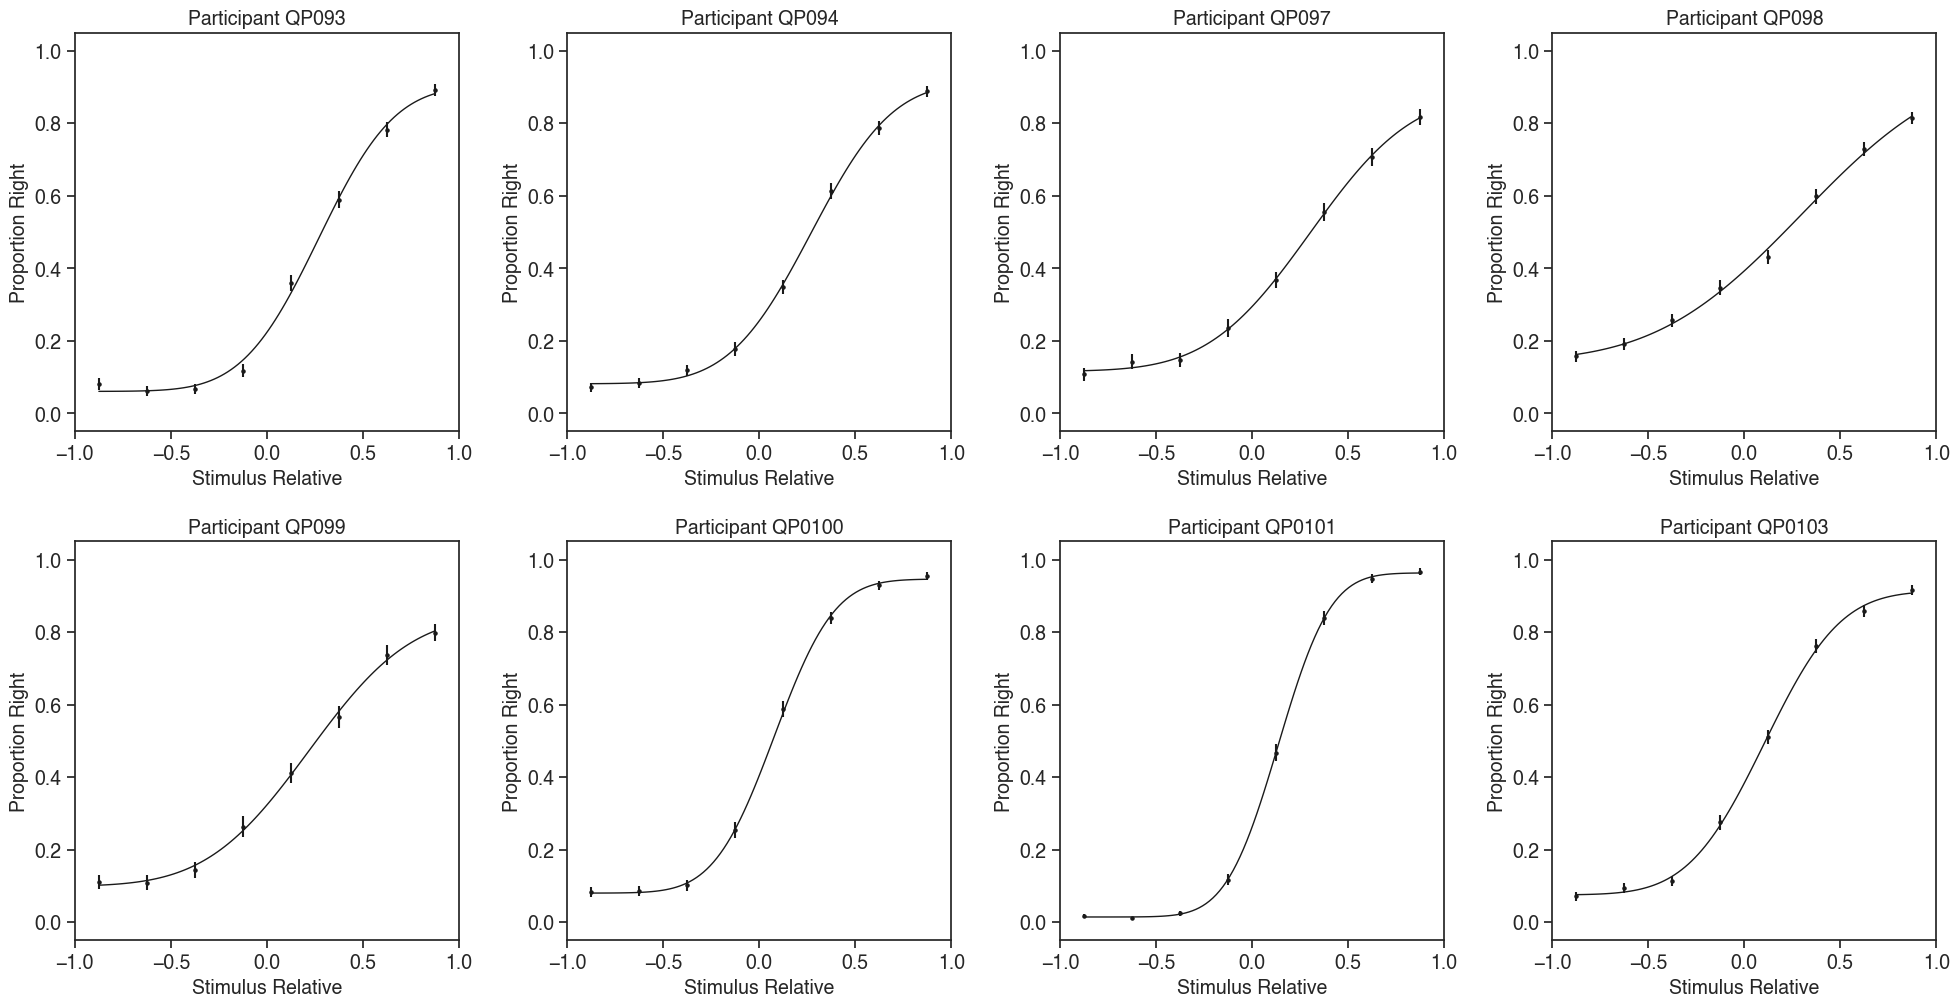

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for i, p_id in enumerate(Animal_List):
    axes[i // 4, i % 4].set_title(f'Participant {p_id}')
    try:
        popt = ut.psycho_fit(sub_df_valid[sub_df_valid['Participant_ID'] == p_id])[0]
        ut.psycho_plot(sub_df_valid[sub_df_valid['Participant_ID'] == p_id],  popt, label=None, color='k', ax=axes[i // 4, i % 4], legend=False)
        axes[i // 4, i % 4].set_ylim(-0.05, 1.05)
        axes[i // 4, i % 4].set_xlabel('Stimulus Relative')
        axes[i // 4, i % 4].set_ylabel('Proportion Right')
    except:
        print(f'Participant {p_id} failed to fit')

for i in range(len(Animal_List), 12):
    fig.delaxes(axes[i // 4, i % 4])

plt.tight_layout()
plt.savefig(figs_path + 'ACC_PPC_Psychometrics_After_2023_11_20.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# w

## GLM quantifying trial history effects

In [ ]:
def add_previous_n_trials_data(group, n=7):
    """
    Add previous n trial data (stim_relative_binned, choice, and correct) to the DataFrame for each participant.
    
    Parameters
    ----------
    group : pd.DataFrame
        The data for a single participant, assumed to have the columns 'Trial', 'No_response',
        'stim_relative_binned', 'choice', and 'correct'.
    n : int
        Number of previous trials to include.
        
    Returns
    -------
    group : pd.DataFrame
        The modified input DataFrame with additional columns for previous trial data
        ('stim_relative_1', 'choice_1', 'correct_1', ... up to n).
    """
    for i in range(1, n+1):
        # Shift the stim_relative_binned, choice, and correct columns by i rows to get previous trial data
        group[f'stim_relative_binned_{i}'] = group['stim_relative_binned'].shift(i)
        group[f'stim_relative_{i}'] = group['Stim_Relative'].shift(i)
        group[f'choice_{i}'] = group['choice'].shift(i)
        group[f'correct_{i}'] = group['correct'].shift(i)
        
        # Set the new columns to NaN for the first i trials of each participant
        group.loc[group['Trial'] < i, [f'stim_relative_{i}', f'choice_{i}', f'correct_{i}']] = np.nan
        
        # Set choice_i and correct_i to NaN for trials where the previous trial had no response
        group.loc[group['No_response'].shift(i) == True, [f'choice_{i}', f'correct_{i}']] = np.nan

    return group

In [ ]:
def prep_GLM_data(df, 
                #   p_id, date, 
                  columns_to_keep, n_trials_back):
    """
    Prepares the data for GLM fitting by adding columns for previous trial data and filtering the dataframe.
    
    Args:
        df (pd.DataFrame): The input dataframe
        p_id (str): The participant ID
        date (str): The date
        columns_to_keep (list): The columns to keep in the output dataframe
        n_trials_back (int): The number of previous trials to include in the output dataframe

    Returns:
        X (pd.DataFrame): The input dataframe (regressors) with additional columns for previous trial data
        y (pd.Series): The choice column (dependent variable)
    """
    # sub_df = df[(df['Participant_ID'] == p_id) & (df['Date'] == date)].reset_index(drop=True)
    sub_df = df.groupby('Participant_ID').apply(add_previous_n_trials_data, n=n_trials_back)
    sub_df = sub_df[columns_to_keep]
    
    # add rewarded and unrewarded choice columns
    for i in range(1, n_trials_back + 1):
        sub_df[f'Rewarded_Choice_{i}'] = np.where((sub_df[f'correct_{i}'] == 1) & (sub_df[f'choice_{i}'] == 1), 1, 
                                              np.where((sub_df[f'correct_{i}'] == 1) & (sub_df[f'choice_{i}'] == 0), -1, 0))
        sub_df[f'Unrewarded_Choice_{i}'] = np.where((sub_df[f'correct_{i}'] == 0) & (sub_df[f'choice_{i}'] == 1), 1, 
                                                np.where((sub_df[f'correct_{i}'] == 0) & (sub_df[f'choice_{i}'] == 0), -1, 0))
        
    sub_df = sub_df[sub_df.No_response == False].reset_index(drop=True)
    # drop any rows where choice_1, stim_relative_1, stim_relative_binned or choice is nan
    sub_df = sub_df.dropna(subset=["stim_relative_binned", "stim_relative_1", "stim_relative_2", "stim_relative_3", 
                                   "stim_relative_4", "stim_relative_5","Rewarded_Choice_1", "Rewarded_Choice_2", 
                                   "Rewarded_Choice_3", "Rewarded_Choice_4", "Rewarded_Choice_5", "Unrewarded_Choice_1",
                                      "Unrewarded_Choice_2", "Unrewarded_Choice_3", "Unrewarded_Choice_4", "Unrewarded_Choice_5",
                                        "choice"]).reset_index(drop=True)
    
    X = sub_df[[
            "Stim_Relative", 
            "stim_relative_1", "stim_relative_2", "stim_relative_3", "stim_relative_4", "stim_relative_5",
            "Rewarded_Choice_1", "Rewarded_Choice_2", "Rewarded_Choice_3", "Rewarded_Choice_4", "Rewarded_Choice_5",
            "Unrewarded_Choice_1", "Unrewarded_Choice_2", "Unrewarded_Choice_3", "Unrewarded_Choice_4", "Unrewarded_Choice_5"
            ]] 
    
    y = sub_df['choice']
    
    return X, y

In [ ]:
p_id = 'QP093'
date = '2023/12/12'
block = 77
sub_df = df[(df['Participant_ID'] == p_id) & (df['Date'] == date) & (df['block'] == block)].reset_index(drop=True)
columns_to_keep = [
                   'Date', 'Participant_ID','Trial', 'Stim_Relative', 'correct', 'No_response',
                   'First_Lick', 'P_Right','Response_Latency', 'Trial_Outcome',
                   'Anti_Bias','Timeout_Duration', 'Emulator', 'Distribution','Datetime',
                   'block', 'Incorrect', 'No_Response', 'choice', 'Rule_Right',
                   'Choice_Rule_Diff', 'stim_relative_binned', 'stim_relative_1',
                   'choice_1', 'correct_1', 'stim_relative_2', 'choice_2', 'correct_2',
                   'stim_relative_3', 'choice_3', 'correct_3', 'stim_relative_4',
                   'choice_4', 'correct_4', 'stim_relative_5', 'choice_5', 'correct_5'
                   ]
X, y = prep_GLM_data(sub_df, columns_to_keep, n_trials_back=5)

In [ ]:
def fit_GLM(X, y):
    """
    Fits a GLM to the data and returns the model.

    Args:
        X (pd.DataFrame): The input dataframe (regressors)
        y (pd.Series): The choice column (dependent variable)

    Returns:
        mean_cv_score (float): The mean cross-validation score
        log_reg_l1 (LogisticRegression): The fitted logistic regression model
    """
    log_reg_l1 = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
    log_reg_l1.fit(X, y)

    # Perform k-fold cross-validation (e.g., k=5)
    k_fold = 5
    cv_scores = cross_val_score(log_reg_l1, X, y, cv=k_fold, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)

    return mean_cv_score, log_reg_l1

In [ ]:
mean_cv_score, log_reg_l1 = fit_GLM(X, y)
print(f'Mean cross-validation score: {mean_cv_score}')

Mean cross-validation score: 0.8533834586466165


In [ ]:
def train_and_evaluate_GLM(X_train, X_test, y_train, y_test):
    '''
    Trains and evaluates a logistic regression model.
    Args:
        X_train (np.array): The training data (regressors)
        X_test (np.array): The testing data (regressors)
        y_train (np.array): The training data (dependent variable)
        y_test (np.array): The testing data (dependent variable)
    Returns:
        coefficients (np.array): The coefficients from the logistic regression model
        intercept (float): The intercept from the logistic regression model
        accuracy (float): The accuracy of the logistic regression model
    '''

    model = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model.coef_[0], model.intercept_[0], accuracy_score(y_test, y_pred)

def gen_coef_df(X, y, bootstrap_samples, n_folds):
    '''
    Generates a DataFrame with regression coefficients, confidence intervals, 
    and model accuracy after bootstrapping.
    Args:
        X (pd.DataFrame): The input data (regressors)
        y (pd.Series): The output data (dependent variable)
        bootstrap_samples (int): The number of bootstrap samples
        n_folds (int): The number of folds for KFold cross-validation
    Returns:
        coef_df (pd.DataFrame): A DataFrame containing the regressors, their 
        coefficients, confidence intervals, and model accuracy.
    '''
    X_np, y_np = X.values, y.values
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)

    results = Parallel(n_jobs=-1)(delayed(train_and_evaluate_GLM)(
        X_np[train_index], X_np[test_index], y_np[train_index], y_np[test_index])
        for i in range(bootstrap_samples) 
        for train_index, test_index in kf.split(X_np))

    coefficients = np.array([coef for coef, _, _ in results])
    intercepts = np.array([intercept for _, intercept, _ in results])
    accuracies = np.array([acc for _, _, acc in results])

    # Calculate the means and confidence intervals for coefficients
    coefficients_mean = np.mean(coefficients, axis=0)
    coefficients_conf_int_low = np.percentile(coefficients, 2.5, axis=0)
    coefficients_conf_int_high = np.percentile(coefficients, 97.5, axis=0)

    # Calculate the mean and confidence intervals for the intercept
    intercept_mean = np.mean(intercepts)
    intercept_conf_int_low = np.percentile(intercepts, 2.5)
    intercept_conf_int_high = np.percentile(intercepts, 97.5)

    # Combine the coefficients and the intercept into the DataFrame
    # Add a new row for the intercept in the DataFrame
    intercept_row = pd.DataFrame({
        'Regressor': ['Intercept'],
        'Coefficient': [intercept_mean],
        'Conf_Int_Low': [intercept_conf_int_low],
        'Conf_Int_High': [intercept_conf_int_high],
        'Accuracy': [np.mean(accuracies)]
    })

    coef_df = pd.DataFrame({
        'Regressor': X.columns,
        'Coefficient': coefficients_mean,
        'Conf_Int_Low': coefficients_conf_int_low,
        'Conf_Int_High': coefficients_conf_int_high
    })
    
    coef_df['Regressor'] = coef_df['Regressor'].replace('Stim_Relative', 'stim_relative_0')


    # Append the intercept row to the coefficients DataFrame
    coef_df = pd.concat([coef_df, intercept_row], ignore_index=True)

    # Add the average accuracy for all models as a new column
    coef_df['Accuracy'] = np.mean(accuracies)

    return coef_df

In [ ]:
coefficients = log_reg_l1.coef_[0]
intercept = log_reg_l1.intercept_[0]
# coef_df = gen_coef_df(X, y, coefficients, intercept, bootstrap_samples = 1000, n_folds = 5)
coef_df = gen_coef_df(X, y, bootstrap_samples = 1000, n_folds = 5)

In [ ]:
def plot_GLM_weights(coef_df, title = 'Regressor Coefficients', save_path=None):
    '''
    Plots the GLM weights for the stimulus and choice regressors, 5 trials back.
    N.b. This function assumes that the regressors are named as follows:
        Stimulus: stim_relative_0, stim_relative_1, stim_relative_2, stim_relative_3, stim_relative_4, stim_relative_5
        Rewarded Choice: Rewarded_Choice_1, Rewarded_Choice_2, Rewarded_Choice_3, Rewarded_Choice_4, Rewarded_Choice_5
        Unrewarded Choice: Unrewarded_Choice_1, Unrewarded_Choice_2, Unrewarded_Choice_3, Unrewarded_Choice_4, Unrewarded_Choice_5
    Args:
        coef_df (pd.DataFrame): The dataframe containing the coefficients, confidence intervals, and accuracy
        save_path (str): The path to save the figure to
    '''
    # Separating the data based on categories
    stim_data = coef_df[coef_df['Regressor'].str.contains('stim')]
    rewarded_data = coef_df[coef_df['Regressor'].str.contains('Rewarded')]
    unrewarded_data = coef_df[coef_df['Regressor'].str.contains('Unrewarded')]

    # Mapping x-axis values
    trial_numbers = np.arange(0, -6, -1)

    plt.figure(figsize=(10, 7))
    background_alpha = 0.8
    try: 
        # Stimulus data
        plt.errorbar(trial_numbers[:6], stim_data['Coefficient'], 
                    yerr=[stim_data['Coefficient'] - stim_data['Conf_Int_Low'], stim_data['Conf_Int_High'] - stim_data['Coefficient']], 
                    fmt='o', color='black', label='Stimulus', alpha=background_alpha)
    except:
        pass # if there are no CIs, just plot the data
    plt.plot(trial_numbers[:6], stim_data['Coefficient'], color='black')


    # Rewarded Choices
    try:
        plt.errorbar(trial_numbers[1:], rewarded_data['Coefficient'], 
                    yerr=[rewarded_data['Coefficient'] - rewarded_data['Conf_Int_Low'], rewarded_data['Conf_Int_High'] - rewarded_data['Coefficient']], 
                    fmt='o', color='blue', label='Rewarded Choice', alpha=background_alpha)
    except:
        pass
    plt.plot(trial_numbers[1:], rewarded_data['Coefficient'], color='blue')

    # Unrewarded Choices
    try:
        plt.errorbar(trial_numbers[1:], unrewarded_data['Coefficient'], 
                    yerr=[unrewarded_data['Coefficient'] - unrewarded_data['Conf_Int_Low'], unrewarded_data['Conf_Int_High'] - unrewarded_data['Coefficient']], 
                    fmt='o', color='red', label='Unrewarded Choice', alpha=background_alpha)
    except:
        pass
    plt.plot(trial_numbers[1:], unrewarded_data['Coefficient'], color='red')

    bias_coef = coef_df[coef_df['Regressor'] == 'Intercept']['Coefficient'].values[0]
    bias_ci_low = coef_df[coef_df['Regressor'] == 'Intercept']['Conf_Int_Low'].values[0]
    bias_ci_high = coef_df[coef_df['Regressor'] == 'Intercept']['Conf_Int_High'].values[0]

    plt.errorbar(-5.5, bias_coef, 
                yerr=[[bias_coef - bias_ci_low], [bias_ci_high - bias_coef]], 
                fmt='o', color='green', label='Bias', alpha=background_alpha)

    # Adding labels and title
    plt.xlabel('Trials Back')
    plt.ylabel('Coefficient')
    plt.title(title)
    plt.axhline(0, color='grey', linestyle='--')
    plt.legend(
        # bbox_to_anchor=(0.0, 1.25), 
               loc='upper left', borderaxespad=0.5)
    # plt.ylim(-6, 6)
    plt.tight_layout()
    fig = plt.gcf()  # Get the current figure

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    return fig

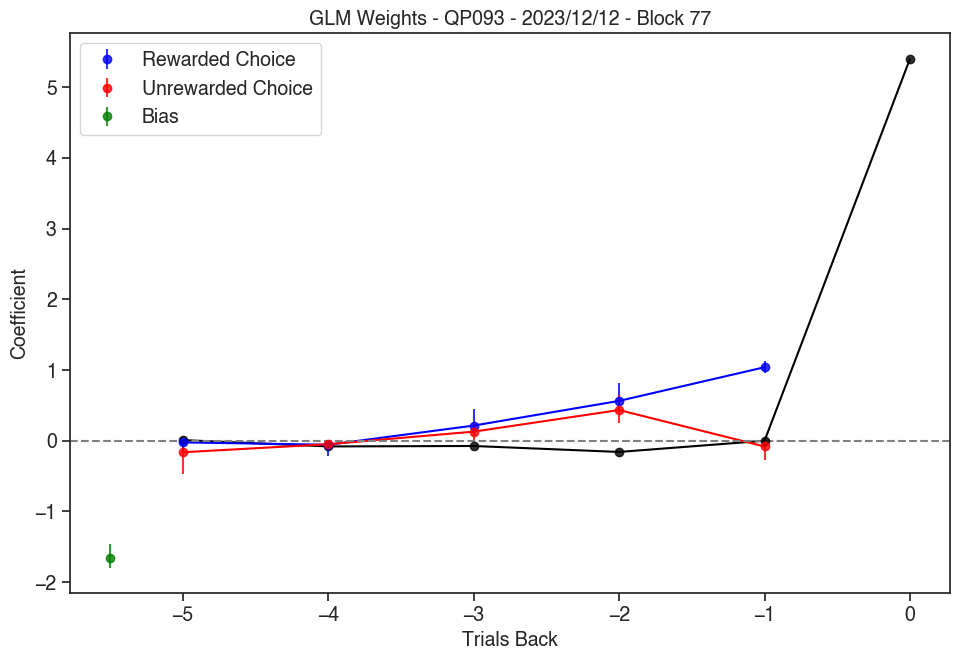

In [ ]:
plot_GLM_weights(coef_df, title =  f'GLM Weights - {p_id} - {date} - Block {block}', save_path=None)

In [ ]:
# Interrupt execution at this cell
raise Exception('Stop Execution')

Exception: Stop Execution

In [ ]:
def plot_GLM_weights_concat(p_id, df, sessions_back = None):
    save_path = figs_path + p_id + '_Trial_History_GLM.pdf'
    sub_df = df[df['Participant_ID'] == p_id].reset_index(drop=True)
    if sessions_back is not None:
        blocks = sub_df['block'].unique()[-sessions_back:]
    else:
        blocks = sub_df['block'].unique()
    with PdfPages(save_path) as pdf:
        for block in blocks:
            block_df = sub_df[sub_df['block'] == block].reset_index(drop=True)
            # print date and block
            date = block_df['Datetime'].iloc[0].strftime('%Y/%m/%d')
            X, y = prep_GLM_data(block_df, columns_to_keep, n_trials_back=5)
            try:
                # _, log_reg_l1 = fit_GLM(X, y)
                # coefficients = log_reg_l1.coef_[0]
                # intercept = log_reg_l1.intercept_[0]
                # coef_df = gen_coef_df(X, y, coefficients = coefficients, intercept = intercept, bootstrap_samples=1000, n_folds=5)
                coef_df = gen_coef_df(X, y, bootstrap_samples = 1000, n_folds = 5)
                fig = plot_GLM_weights(coef_df, title=f'{p_id} - {date} - Block {block}')
                pdf.savefig(fig)
                plt.close(fig)
            except:
                print(f'Participant {p_id} - Block {block} failed to fit')

In [ ]:
for p_id in Animal_List:
    print(f'Processing {p_id}')
    plot_GLM_weights_concat(p_id, df, sessions_back = 25)
    plt.close('all')

Processing QP093
Participant QP093 - Block 111.0 failed to fit
Participant QP093 - Block 112.0 failed to fit
Participant QP093 - Block 114.0 failed to fit
Processing QP094
Participant QP094 - Block 121.0 failed to fit
Participant QP094 - Block 123.0 failed to fit
Participant QP094 - Block 125.0 failed to fit
Participant QP094 - Block 126.0 failed to fit
Processing QP097
Processing QP098
Processing QP099
Processing QP0100
Participant QP0100 - Block 103.0 failed to fit
Participant QP0100 - Block 105.0 failed to fit
Processing QP0101
Processing QP0119
Participant QP0119 - Block 0.0 failed to fit
Participant QP0119 - Block 1.0 failed to fit
Processing QP0120
Participant QP0120 - Block 0.0 failed to fit
Participant QP0120 - Block 1.0 failed to fit
Processing QP0121
Participant QP0121 - Block 0.0 failed to fit
Participant QP0121 - Block 1.0 failed to fit
Participant QP0121 - Block 8.0 failed to fit
Participant QP0121 - Block 12.0 failed to fit
Processing QP0122
Participant QP0122 - Block 5.0

In [ ]:
p_ids = df['Participant_ID'].unique()
sub_df = df[df['Participant_ID'].isin(p_ids)].reset_index(drop=True)
date_limit = '2023/11/30'
sub_df = sub_df[sub_df['Date'] >= date_limit].reset_index(drop=True)
# remove blocks with less than 100 rows/trials
sub_df = filter_min_rows(sub_df, threshold=100, iterator='Participant_ID', feature='block')

In [ ]:
p_ids = sub_df['Participant_ID'].unique()
psych_params_df = ut.gen_blockwise_psych_params(sub_df, p_ids)

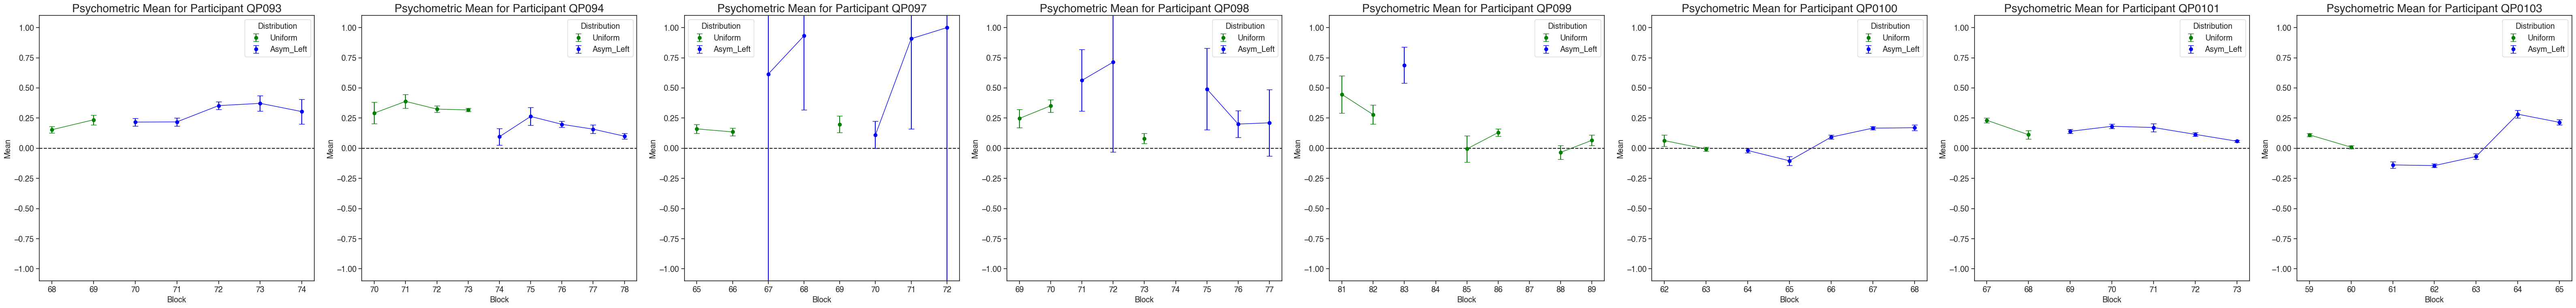

In [ ]:
fig, axes = plt.subplots(1, len(p_ids), figsize=(len(p_ids) * 8, 8))

color_dict = {'Uniform': 'green', 'Asym_Left': 'blue', 'Asym_Right': 'red'}
for i, p_id in enumerate(p_ids):
    ax = axes[i]  # Select the i-th subplot
    pid_df = psych_params_df[psych_params_df['Participant_ID'] == p_id]

    # Iterate over each unique distribution
    for dist in pid_df['Distribution'].unique():
        dist_df = pid_df[pid_df['Distribution'] == dist].sort_values(by='Block')

        # Plot error bars for each distribution
        ax.errorbar(x=dist_df['Block'], y=dist_df['Block_Means'], yerr=dist_df['Block_Means_Std'], fmt='o', ecolor=color_dict[dist], capsize=5, label=dist, color=color_dict[dist]) 

        # Plot lines for adjacent blocks within the same distribution
        for k, grp in dist_df.groupby((dist_df['Block'].diff() != 1).cumsum()):
            ax.plot(grp['Block'], grp['Block_Means'], color=color_dict[dist], linestyle='-', linewidth=1)

    ax.set_title(f'Psychometric Mean for Participant {p_id}', fontdict={'fontsize': 20})
    ax.legend(title='Distribution')
    ax.axhline(y=0, color='k', linestyle='--')
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlabel('Block')
    ax.set_ylabel('Mean')

# Adjust layout to prevent overlap
plt.tight_layout()
# save the figure as a pdf in the figures folder
# plt.savefig(figs_path + 'QP0100_QP0103_Psychometrics_Mean.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Psychometric for different distributions

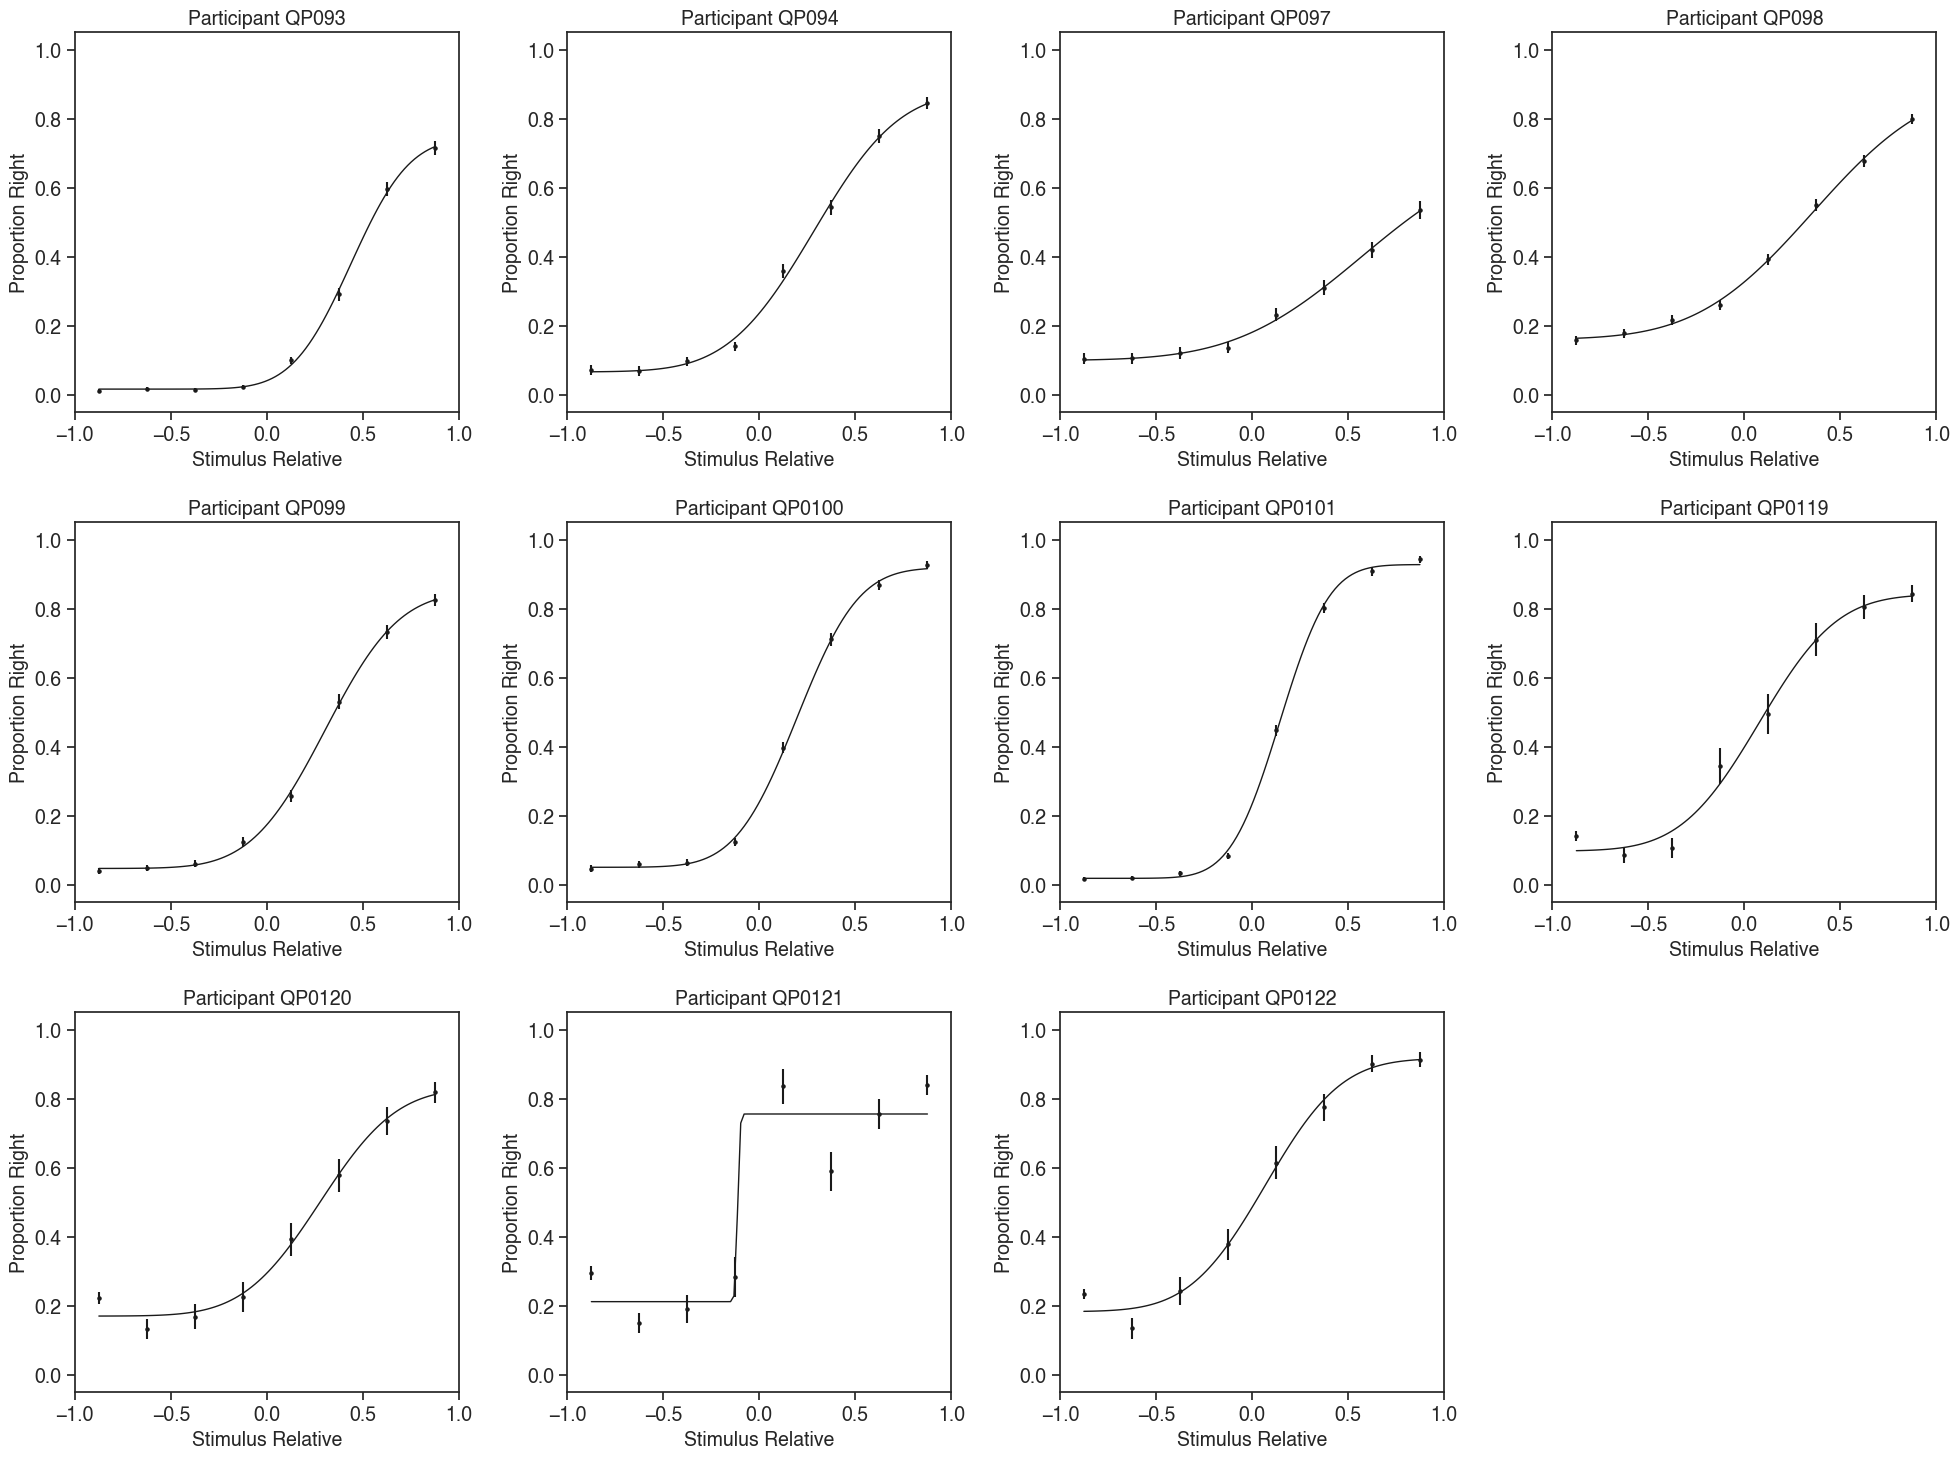

In [13]:
# date = '2023/11/30'
dates = [
    # '2024/01/01',
    # '2024/01/02',
    '2024/01/03',
    '2024/01/04',
    '2024/01/05',
    '2024/01/06',
    '2024/01/07',
    '2024/01/08',
    '2024/01/09',
    '2024/01/10',
    '2024/01/11',
    '2024/01/12',
    '2024/01/13',
    '2024/01/14',
    '2024/01/15',
    '2024/01/16',
    '2024/01/17',
    '2024/01/18',
    '2024/01/19',
    '2024/01/20',
    '2024/01/21',
    '2024/01/22',
    '2024/01/23',
    '2024/01/24',
    '2024/01/25',
    '2024/01/26',
    '2024/01/27',
    '2024/01/28',
    '2024/01/29',
    '2024/01/30',
    '2024/01/31',
    '2024/02/01',
    '2024/02/02',
    '2024/02/03',
    '2024/02/04',
    '2024/02/05',
    '2024/02/06',
    '2024/02/07',
    '2024/02/08',
    '2024/02/09',
    '2024/02/10',
    '2024/02/11',
    '2024/02/12',
    '2024/02/13',
    '2024/02/14',
    '2024/02/15',
    '2024/02/16',
]

# date_df = df[df['Date'] == date]
date_df = df[df['Date'].isin(dates)]
date_df = date_df[date_df['No_response'] == False].reset_index(drop=True)

fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for i, p_id in enumerate(Animal_List):
    axes[i // 4, i % 4].set_title(f'Participant {p_id}')
    try:
        popt = ut.psycho_fit(date_df[date_df['Participant_ID'] == p_id])[0]
        ut.psycho_plot(date_df[date_df['Participant_ID'] == p_id],  popt, label=None, color='k', ax=axes[i // 4, i % 4], legend=False)
        axes[i // 4, i % 4].set_ylim(-0.05, 1.05)
        axes[i // 4, i % 4].set_xlabel('Stimulus Relative')
        axes[i // 4, i % 4].set_ylabel('Proportion Right')
    except:
        print(f'Participant {p_id} failed to fit')

for i in range(len(Animal_List), 12):
    fig.delaxes(axes[i // 4, i % 4])

plt.tight_layout()
# plt.savefig(figs_path + 'ACC_PPC_Psychometrics_2023_11_29.pdf', dpi=300, bbox_inches='tight')
plt.show()

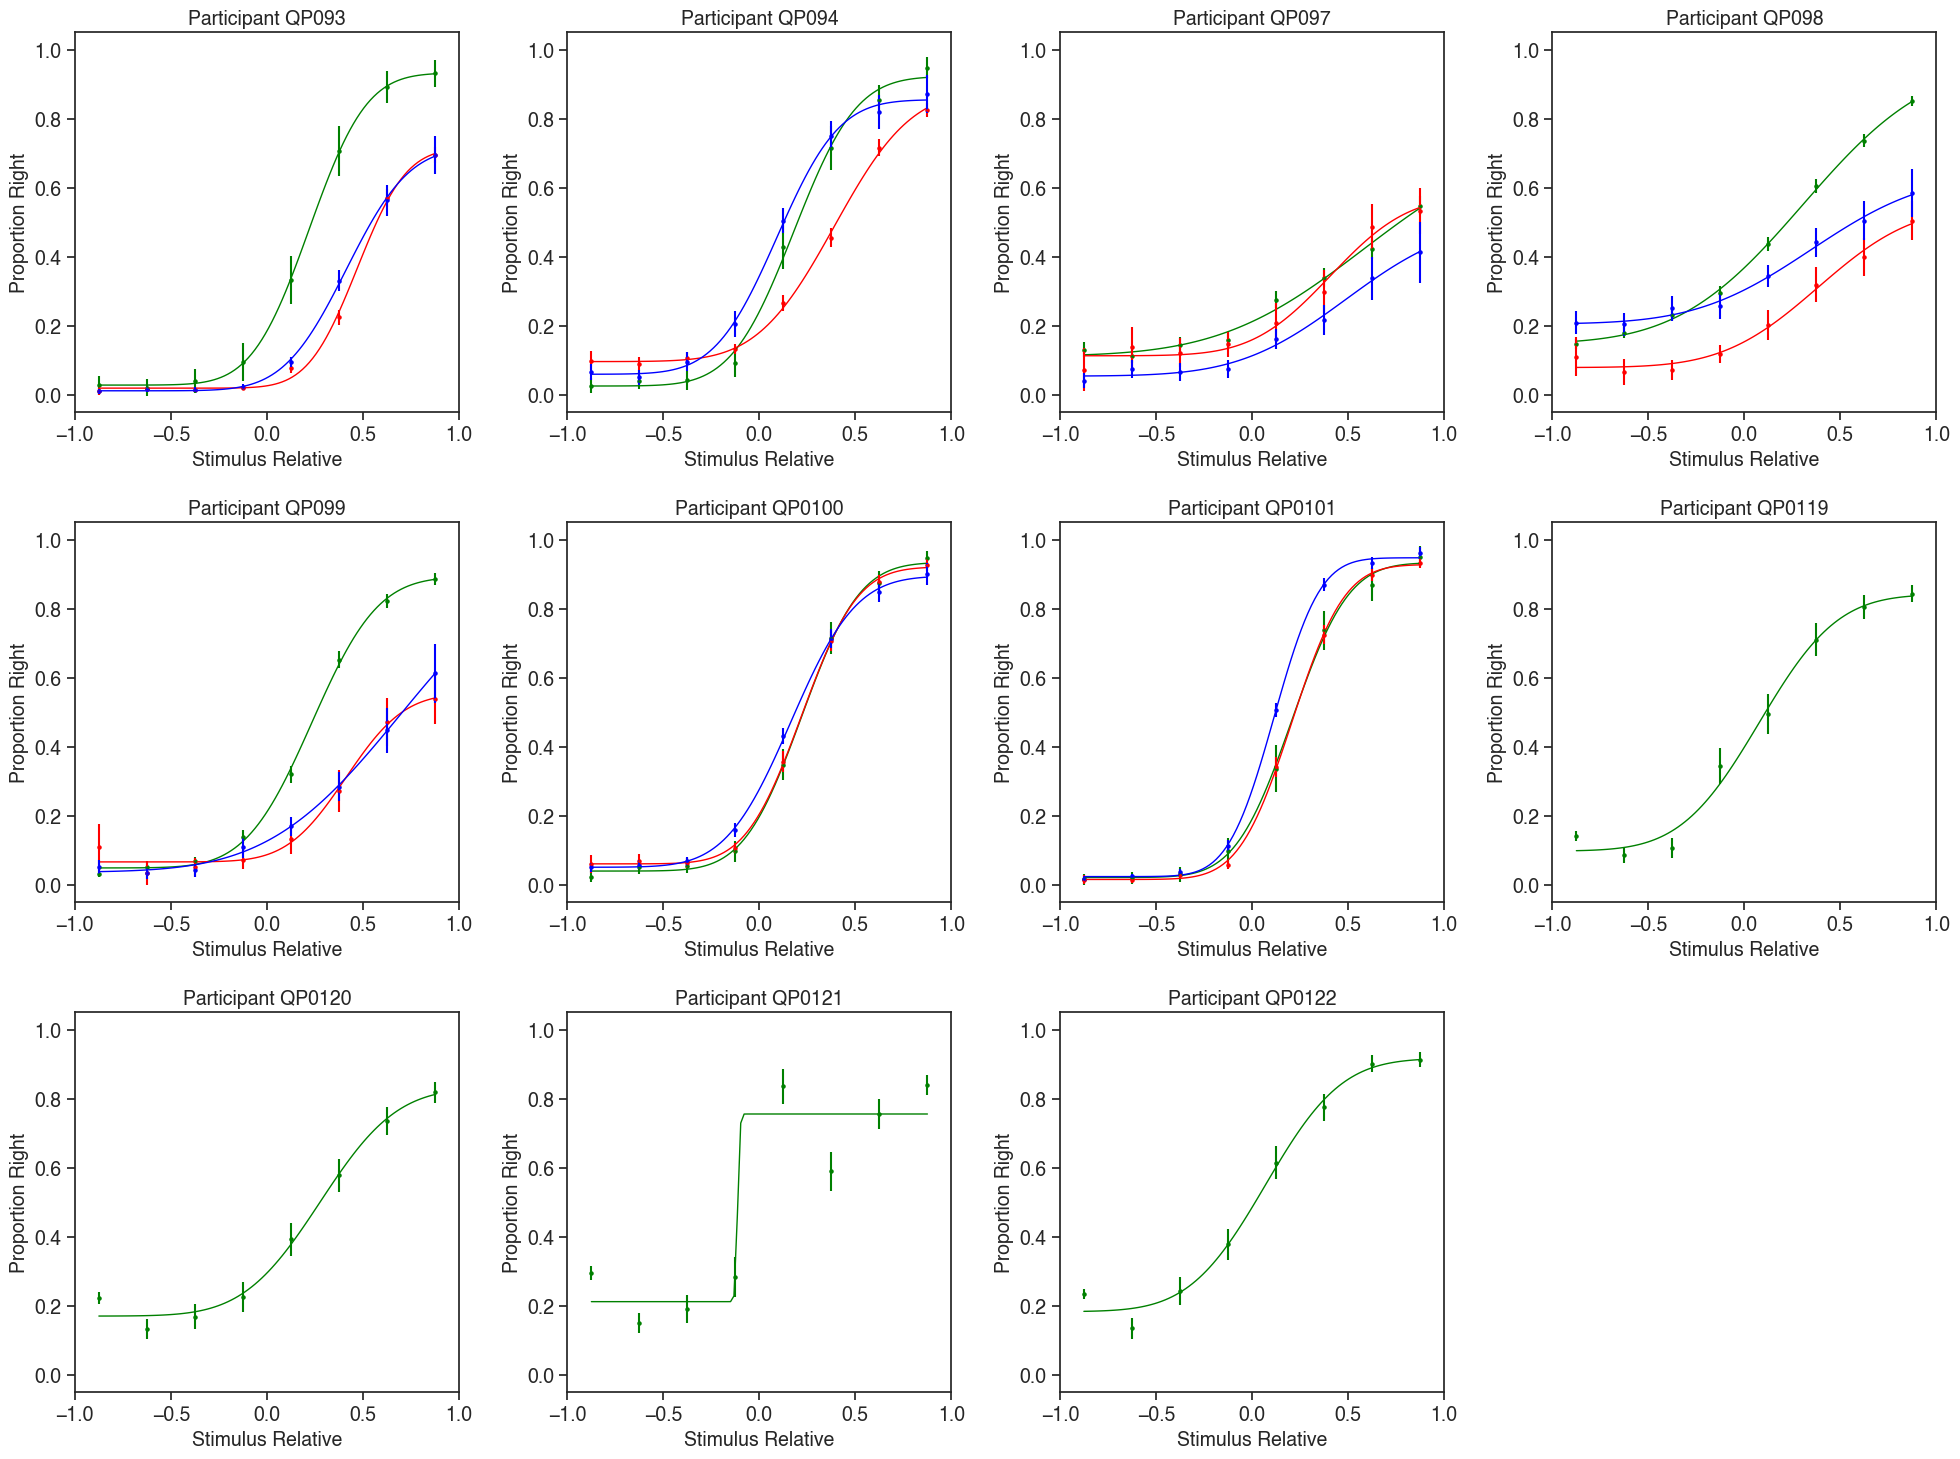

In [14]:
# Create subplots for each animal
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

color_dict = {'Uniform': 'green', 'Asym_Left': 'blue', 'Asym_Right': 'red'}

# generate the same plots, but now only seperarting by distribution
for i, p_id in enumerate(Animal_List):
    ax = axes[i // 4, i % 4]
    ax.set_title(f'Participant {p_id}')

    participant_df = date_df[date_df['Participant_ID'] == p_id]
    if not participant_df.empty:
        for distribution in participant_df['Distribution'].unique():
            dist_df = participant_df[participant_df['Distribution'] == distribution]
            if not dist_df.empty:
                try:
                    popt = ut.psycho_fit(dist_df)[0]
                    ut.psycho_plot(dist_df, popt, label=distribution, color=color_dict[distribution], ax=ax, legend=False)
                except Exception as e:
                    print(f'Participant {p_id} failed to fit on {distribution}: {e}')

    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('Stimulus Relative')
    ax.set_ylabel('Proportion Right')
    # ax.get_legend().remove()

# Remove unused axes
for i in range(len(Animal_List), 12):
    axes_to_del = axes[i // 4, i % 4]
    fig.delaxes(axes_to_del)

plt.tight_layout()
# plt.savefig(figs_path + 'ACC_PPC_Psychometrics_Distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
p_ids = ['QP093', 'QP094', 
        #  'QP097',
          'QP098', 'QP099', 'QP0100', 'QP0101']
psych_params_df = ut.gen_blockwise_psych_params(date_df, p_ids)

/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3

/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3

/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3

/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [16]:
# rename the "Block" column to "block" in the psych_params_df dataframe
psych_params_df = psych_params_df.rename(columns={'Block': 'block'})

# Identifying composite key columns
composite_keys = ['Participant_ID', 'block']  # Replace with the actual key column names

# Dropping duplicate rows in data_df based on composite keys
data_df_unique = date_df.drop_duplicates(subset=composite_keys)

# Columns from data_df to merge
columns_to_merge = ['Opto_On', 'Fiber', 'Mask', 'Zapit', 'Stimulation_Site', 'Opto_Condition']

# Merging
psych_params_df = psych_params_df.merge(data_df_unique[composite_keys + columns_to_merge], 

                                        on=composite_keys, how='left')

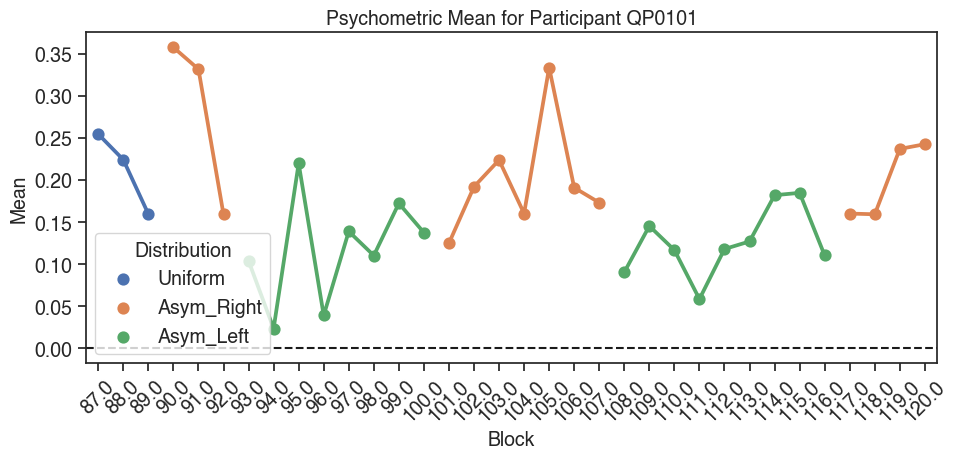

In [17]:
# plot Block_Means Vs Block for QP0101

fig, ax = plt.subplots(figsize=(10, 5))

sns.pointplot(data=psych_params_df[psych_params_df['Participant_ID'] == 'QP0101'], x='block', y='Block_Means', hue='Distribution', ax=ax)

# rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('Psychometric Mean for Participant QP0101')
ax.set_xlabel('Block')
ax.set_ylabel('Mean')
ax.axhline(y=0, color='k', linestyle='--')
ax.legend(title='Distribution')
plt.tight_layout()
plt.show()

In [18]:

# psych_params_clean_df = psych_params_df[psych_params_df.Block_Means_Std < 2].reset_index(drop=True)
# # only keep rows where Block_Means is greater that -0.8 and less than 0.8
# psych_params_clean_df = psych_params_clean_df[(psych_params_clean_df.Block_Means > -0.8) & 
#                                               (psych_params_clean_df.Block_Means < 0.8)].reset_index(drop=True)# # remove rows where Block_Means_Std is greater than 2
psych_params_clean_df = psych_params_df

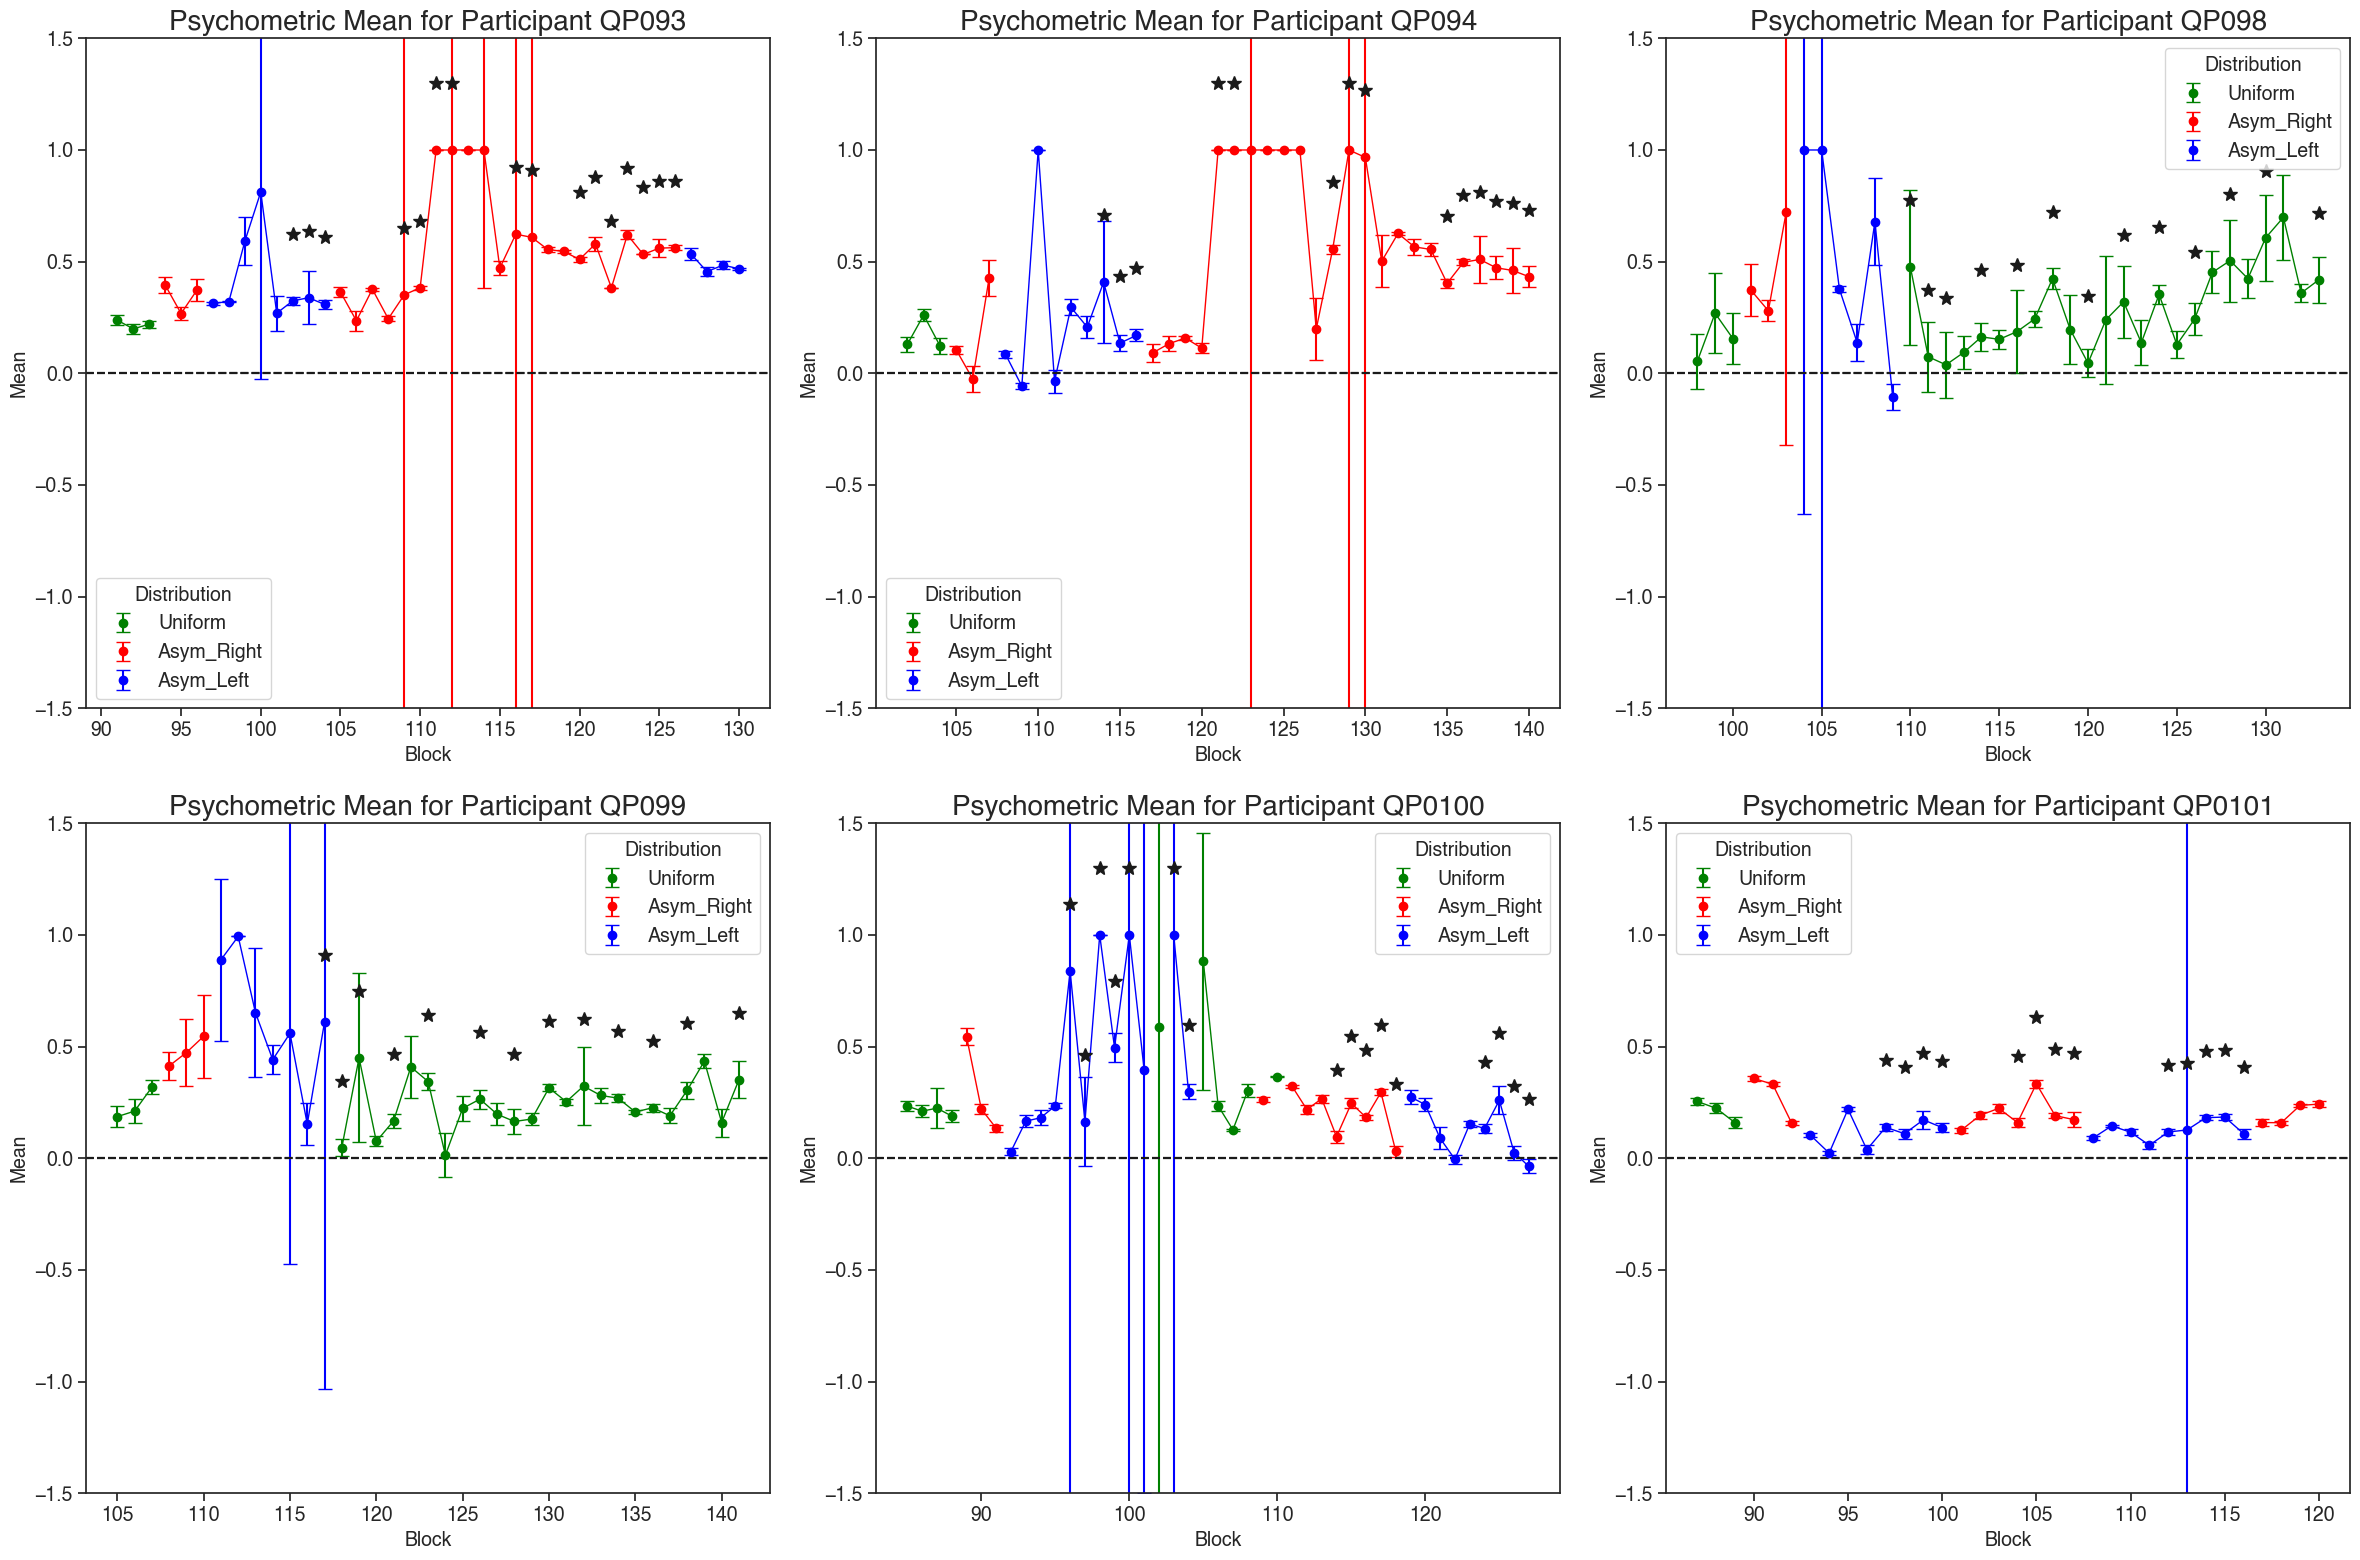

In [19]:
# Define the number of rows and columns for the subplots
n_rows = 2
n_cols = (len(p_ids) + n_rows - 1) // n_rows  # Calculate the number of columns needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 8))

color_dict = {'Uniform': 'green', 'Asym_Left': 'blue', 'Asym_Right': 'red'}

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

for i, p_id in enumerate(p_ids):
    ax = axes[i]  # Select the i-th subplot
    pid_df = psych_params_clean_df[psych_params_clean_df['Participant_ID'] == p_id]

    # Iterate over each unique distribution
    for dist in pid_df['Distribution'].unique():
        dist_df = pid_df[pid_df['Distribution'] == dist].sort_values(by='block').reset_index(drop=True)

        # Check if the dataframe is not empty and the yerr column contains valid data
        try:            
            # Plot error bars for each distribution
            ax.errorbar(x=dist_df['block'], y=dist_df['Block_Means'], 
                        yerr=dist_df['Block_Means_Std'], 
                        fmt='o', ecolor=color_dict[dist], capsize=5, label=dist, color=color_dict[dist]) 

            # Plot lines for adjacent blocks within the same distribution
            for k, grp in dist_df.groupby((dist_df['block'].diff() != 1).cumsum()):
                ax.plot(grp['block'], grp['Block_Means'], color=color_dict[dist], linestyle='-', linewidth=1)
            
            # Plot a star for each point where 'Opto_On' is True
            for index, row in dist_df.iterrows():
                if row['Opto_On']:
                    ax.plot(row['block'], row['Block_Means'] + 0.3, '*', color='k', markersize=10)  # Adjust the 0.1 offset and markersize as needed

        except Exception as e:
            print(f'Participant {p_id} failed to plot: {e}')

        ax.set_title(f'Psychometric Mean for Participant {p_id}', fontdict={'fontsize': 20})
        ax.legend(title='Distribution')
        ax.axhline(y=0, color='k', linestyle='--')
        ax.set_ylim(-1.5, 1.5)
        ax.set_xlabel('Block')
        ax.set_ylabel('Mean')

# Remove any empty subplots if the number of plots is less than n_rows * n_cols
for i in range(len(p_ids), n_rows * n_cols):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
# Break execution at this cell
raise Exception('Stop Execution')

Exception: Stop Execution

## NEW DATA LOADING WITH PARAMS

In [9]:
# data_path = '/Users/quentin/Desktop/Python_Sandbox/Subjects/'
data_path = '/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/'
protocol = 'SOUND_CAT'
data_type = 'Trial_Summary'
Animal_ID = 'QP094'

In [10]:
def find_closest_timestamp(target, timestamps):
    """
    Finds the closest timestamp to the target.

    Args:
        target (str): The target timestamp.
        timestamps (list): List of available timestamps.

    Returns:
        str: The closest timestamp.
    """
    target_dt = datetime.datetime.strptime(target, '%Y-%m-%dT%H_%M_%S')
    closest = min(timestamps, key=lambda ts: abs(datetime.datetime.strptime(ts, '%Y-%m-%dT%H_%M_%S') - target_dt))
    return closest

def get_sessions_params_as_df(df, n_rows):
    """
    Args:
        df (pd.DataFrame): dataframe containing all the data for the animal
        n_rows (int): number of rows to use for the new dataframe
    Returns:
        new_df (pd.DataFrame): dataframe containing the session parameters
    """

    # We will only use the first row of the original DataFrame for transformation
    row_values = df.iloc[0, :].values

    # Split the values into even-indexed for column names and odd-indexed for column values
    column_names = row_values[::2]  # Take every second value starting from 0 for column names
    column_values = row_values[1::2]  # Take every second value starting from 1 for column values

    # Create a dictionary for the new DataFrame with column names and corresponding values
    data_dict = {column_names[i]: [column_values[i]] * n_rows for i in range(len(column_names))}

    # Create the new DataFrame
    params_df = pd.DataFrame(data_dict)

    return params_df

def read_csv_with_fallback_encodings(file_path, encodings=['utf-8', 'ISO-8859-1', 'cp1252']):
    for encoding in encodings:
        try:
            return pd.read_csv(file_path, encoding=encoding)
        except UnicodeDecodeError:
            continue
    raise UnicodeDecodeError(f"Could not read file {file_path} with any of the provided encodings: {encodings}")

def read_csv_ignore_encoding_errors(file_path):
    with open(file_path, 'rb') as file:
        content = file.read()  # Read the file as binary
        content_decoded = content.decode('utf-8', errors='ignore')  # Decode, ignoring errors
    return pd.read_csv(io.StringIO(content_decoded))

def read_csv_with_alternate_encoding(file_path):
    try:
        return pd.read_csv(file_path, encoding='utf-8')
    except UnicodeDecodeError:
        return pd.read_csv(file_path, encoding='ISO-8859-1')
    
def read_csv_forcefully(file_path):
    with open(file_path, 'rb') as file:
        content = file.read()  # Read the file as binary
        content_decoded = content.decode('ISO-8859-1')  # Decode using 'ISO-8859-1'
    return pd.read_csv(io.StringIO(content_decoded))

def concat_trial_data_with_params(folder_path):
    pattern = re.compile(r'\d{4}-\d\d-\d\dT\d\d_\d\d_\d\d')
    trial_summary_files = {}
    session_params_files = {}
    misread_files = []

    for file in os.listdir(folder_path):
        if file.startswith("._"):
            continue
        match = pattern.search(file)
        if match:
            timestamp = match.group()
            if 'Trial_Summary' in file:
                trial_summary_files[timestamp] = file
            elif 'Session_Parameters' in file:
                session_params_files[timestamp] = file

    all_dataframes = []

    for ts_summary, summary_file in trial_summary_files.items():
        file_path = os.path.join(folder_path, summary_file)
        # print(file_path)

        try:
            # Attempt to read the file with utf-8 encoding
            trial_summary_df = pd.read_csv(file_path, encoding='utf-8')
        except UnicodeDecodeError:
            # If utf-8 fails, try reading with ISO-8859-1
            try:
                trial_summary_df = pd.read_csv(file_path, encoding='ISO-8859-1')
            except Exception as e:
                # If alternative encoding also fails, add to misread_files and skip this file
                misread_files.append(file_path)
                print(f"Failed to read file {summary_file} with both UTF-8 and ISO-8859-1 encodings: {e}")
                continue  # Proceed to the next file
        except Exception as e:
            # Catch all other exceptions
            misread_files.append(file_path)
            print(f"An error occurred while processing file {summary_file}: {e}")
            continue
        concatenated_df = trial_summary_df  # Default to just the trial summary data

            # Standardize column name
        if 'Trial_End_Time' not in trial_summary_df.columns:
            if 'Time' in trial_summary_df.columns:
                trial_summary_df.rename(columns={'Time': 'Trial_End_Time'}, inplace=True)
            else:
                print(f"The file {file_path} does not contain 'Trial_End_Time' or 'Time' column. Skipping.")
                misread_files.append(file_path)  # Optionally add to misread_files
            continue  # Skip further processing for this file
        
        nan_indices = trial_summary_df['Trial_End_Time'].isna()
        # forwards fill the nan values in the Trial_End_Time column
        trial_summary_df['Trial_End_Time'] = trial_summary_df['Trial_End_Time'].fillna(method='ffill')
        # Add an arbitrary value of 0.01 seconds to the 'Trial_End_Time' where NaNs were present
        # 0.01 seconds is 0.01/86400 in fractional days
        trial_summary_df.loc[nan_indices, 'Trial_End_Time'] += 0.01/86400

        date_pattern = r'\d{4}_\d{1,2}_\d{1,2}'
        date = re.search(date_pattern, file_path).group(0)
        date_obj = datetime.datetime.strptime(date, '%Y_%m_%d')
        formatted_date = date_obj.strftime('%Y/%m/%d')
        trial_summary_df.insert(0, 'Date', formatted_date)
        trial_summary_file_path = folder_path + '/' + summary_file
        trial_summary_df['File_ID'] = trial_summary_file_path  # Add file identifier
        # print(trial_summary_file_path)
        closest_ts = find_closest_timestamp(ts_summary, session_params_files.keys())
        params_file = session_params_files.get(closest_ts, None)

        # # Check if session parameters file exists and is not empty
        # if params_file and os.path.getsize(os.path.join(folder_path, params_file)) > 0:
        #     print('Session params file exists and is not empty')
        #     session_params_df = pd.read_csv(os.path.join(folder_path, params_file))

        #     if not session_params_df.empty:
        #         print('Session params file is not empty')
        #         # Transform the session parameters dataframe
        #         transformed_session_params_df = get_sessions_params_as_df(session_params_df, len(trial_summary_df))
        #         # Rename columns to ensure uniqueness
        #         # transformed_session_params_df.rename(columns=lambda x: x + '_params', inplace=True)
        #         concatenated_df = pd.concat([trial_summary_df, transformed_session_params_df], axis=1)
        #         # drop duolicate columns
        #         concatenated_df = concatenated_df.loc[:,~concatenated_df.columns.duplicated()]
        #     else:
        #         print('Session params file is empty')
        #         concatenated_df = trial_summary_df
        # else:
        #     print('Session params file does not exist or is empty')
        #     concatenated_df = trial_summary_df

            # Check if session parameters file exists and is not empty
        if params_file and os.path.getsize(os.path.join(folder_path, params_file)) > 0:
            encodings = ['utf-8', 'ISO-8859-1', 'latin1']  # List of encodings to try
                        # Your file processing loop
            for encoding in encodings:
                try:
                    session_params_df = pd.read_csv(os.path.join(folder_path, params_file), encoding=encoding)
                    break  # Successfully read, break the encoding loop
                except UnicodeDecodeError:
                    continue  # Try the next encoding
            # session_params_df = pd.read_csv(os.path.join(folder_path, params_file))
            if not session_params_df.empty:
                # Process session parameters and concatenate
                transformed_session_params_df = get_sessions_params_as_df(session_params_df, len(trial_summary_df))
                concatenated_df = pd.concat([trial_summary_df, transformed_session_params_df], axis=1)
                concatenated_df = concatenated_df.loc[:,~concatenated_df.columns.duplicated()]



            # Process the DataFrame as needed (omitted for brevity)

            # Append the processed DataFrame to all_dataframes
        all_dataframes.append(concatenated_df)  # Assuming trial_summary_df is processed correctly

    # Concatenate all successfully processed DataFrames
    if all_dataframes:
        final_dataframe = pd.concat(all_dataframes, ignore_index=True, sort=False)
    else:
        final_dataframe = pd.DataFrame()  # Return an empty DataFrame if no files were successfully processed

    return final_dataframe

def read_csv_with_fallback(file_path):
    # Attempt to detect encoding
    try:
        with open(file_path, 'rb') as f:
            result = chardet.detect(f.read())
            encoding = result['encoding']
        return pd.read_csv(file_path, encoding=encoding, errors='replace')
    except UnicodeDecodeError:
        # If decoding fails, try reading with 'ISO-8859-1' or another suitable fallback
        try:
            return pd.read_csv(file_path, encoding='ISO-8859-1', errors='replace')
        except Exception as e:
            print(f"Failed to process {file_path} with fallback encoding: {e}")
            # Return None or handle it as needed
            return None
    except Exception as e:
        print(f"An unexpected error occurred while processing {file_path}: {e}")
        # Return None or handle it as needed
        return None
    
def get_animal_data(data_path, Animal_ID, protocol, data_type):
    """
    Args:
        data_path (str): path to the data folder
        Animal_ID (str): animal ID
        protocol (str): protocol name
        data_type (str): data type (e.g. 'Trial_Summary', 'Detected_Licks')
    Returns:
        animal_df (pd.DataFrame): dataframe containing all the data for the animal
    """

    subject_folders = glob.glob(data_path + Animal_ID +'/*') 
    protocol_folders = list(filter(lambda x: protocol + '_' + Animal_ID in x, subject_folders))
    # misread_files = []

    if len(protocol_folders) == 0:
        warnings.warn(f"{Animal_ID}: all_folders empty")
        return 0
        # return pd.DataFrame(), []


    sessions_data = []
    for folder in tqdm(protocol_folders, position=0, leave=True, desc = 'Processing ' + Animal_ID):
        try:
            folder_data = concat_trial_data_with_params(folder)
            sessions_data.append(folder_data)
            # misread_files.extend(folder_misread_files)  # Correct extension of misread_files

        except Exception as e:
            print(f"An error occurred while processing folder {folder}: {e}")

    animal_df = pd.concat(sessions_data, axis=0, ignore_index=True)

    # Create a list of columns for sorting
    sort_columns = ['Date']

    # Check which of the columns ('Trial_End_Time' or 'Time') exists in the DataFrame
    if 'Trial_End_Time' in animal_df.columns:
        sort_columns.append('Trial_End_Time')
    elif 'Time' in animal_df.columns:
        sort_columns.append('Time')

    # Sort the DataFrame by the determined columns
    animal_df = animal_df.sort_values(by=sort_columns)

    date_list = []
    for date in animal_df.Date.unique():
        date_df = animal_df[animal_df.Date == date].reset_index(drop=True)
        date_list.append(date_df)

    animal_df = pd.concat(date_list, axis=0, ignore_index=True)

    return animal_df

In [11]:
data_path = '/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/'
# data_path = '/Users/quentin/Desktop/Python_Sandbox/Subjects/'
protocol = 'SOUND_CAT'
data_type = 'Trial_Summary'

Animal_List = [
    'QP093', 
    'QP094', 
    'QP097', 
    'QP098', 'QP099', 
               'QP0100', 'QP0101', 
               'QP0119', 'QP0120', 'QP0121',
               'QP0122',
               ] 

# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_data_SC_V2.pkl")

# Define the path to the figures
figs_path = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:       
        all_data_SC_V2 = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    all_data_SC_V2 = pd.DataFrame()
    for animal in Animal_List:
        # try:
        #     # Load the data for the current animal and add it to the dictionary
        #     animal_data = get_animal_data(data_path,
        #                                      animal, 
        #                                      protocol,
        #                                      data_type)
        #     all_data_SC_V2 = pd.concat([all_data_SC_V2, animal_data])
        # except:
        #     # If there is an error loading the data, skip the current animal
        #     pass
        # for animal in Animal_List:
        try:
            animal_data = get_animal_data(data_path, animal, protocol, data_type)
            print(f"Animal {animal} data shape: {animal_data.shape}")  # Debug print
            all_data_SC_V2 = pd.concat([all_data_SC_V2, animal_data])
            print(f"After concatenating {animal}, all_data_SC_V2 shape: {all_data_SC_V2.shape}")  # Debug print
        except Exception as e:
            print(f"Error processing {animal}: {e}")  # Log any errors

    print(f"Final all_data_SC_V2 shape: {all_data_SC_V2.shape}")  # Debug print before saving

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(all_data_SC_V2, f)

In [12]:
# Processing the data
df = all_data_SC_V2.copy()
df['Datetime'] = pd.to_datetime(df['Date'])
df['Animal_ID'] = pd.Categorical(df['Animal_ID'], categories=Animal_List, ordered=True)

df = add_block_column(df, participant_col='Animal_ID', datetime_col='Datetime', 
                             trial_end_time='Trial_End_Time', trial_col='Trial_Number')

df = df.assign(
    Correct=lambda x: (x['Trial_Outcome'] == 'Correct').astype(int),
    Incorrect=lambda x: (x['Trial_Outcome'] == 'Incorrect').astype(int),
    No_Response=lambda x: (x['Trial_Outcome'] == 'Abort').astype(int),
    choice=lambda x: (x['First_Lick'] == 'Right').astype(int),
    block=lambda x: x['block'] - 1,
    Trial_Number=lambda x: x['Trial_Number'] - 1
)

df.rename(columns={
    'Animal_ID': 'Participant_ID', 
    'Trial_Number': 'Trial',
    'Correct': 'correct',
    'Abort_Trial': 'No_response'
}, inplace=True)

df['Rule_Right'] = (df['Stim_Relative'] > 0).astype(int)
df['Choice_Rule_Diff'] = df['choice'] - df['Rule_Right']

no_response_mask = df['No_response'] == 1
df.loc[no_response_mask, ['correct', 'choice', 'Response_Latency', 'Choice_Rule_Diff']] = np.nan

bins = [-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0]
labels = [-0.875, -0.625, -0.375, -0.125, 0.125, 0.375, 0.625, 0.875]

df['stim_relative_binned'] = pd.cut(
    df['Stim_Relative'], bins=bins, labels=labels, right=False, include_lowest=True
).astype(float)
df.reset_index(drop=True, inplace=True)
df['Opto_Condition'] = df.apply(lambda row: row['Stimulation_Site'] if row['Opto_On'] else 'No_Stim', axis=1)

In [ ]:
p_ids = ['QP098', 'QP099']
sub_df = df[df['Participant_ID'].isin(p_ids)].reset_index(drop=True)
date_limit = '2024/01/17'
sub_df = sub_df[sub_df['Date'] >= date_limit].reset_index(drop=True)
# remove no response trials
sub_df = sub_df[sub_df['No_response'] == False].reset_index(drop=True)
# convert the Participant_ID column to a string
sub_df['Participant_ID'] = sub_df['Participant_ID'].astype(str)

In [ ]:
grouped_df_means = sub_df.groupby(['Participant_ID', 'block', 'Date',
            'Opto_Condition',
            'Distribution'
            ])['correct', 'choice'].mean().reset_index()             

# rename the 'correct' and 'choice' columns to 'correct_mean' and 'choice_mean' respectively
grouped_df_means.rename(columns={'correct': 'correct_mean', 'choice': 'choice_mean'}, inplace=True)

grouped_df_sems = sub_df.groupby(['Participant_ID', 'block', 'Date',
            'Opto_Condition',
            'Distribution'
            ])['correct', 'choice'].sem().reset_index()  

# rename the 'correct' and 'choice' columns to 'correct_sem' and 'choice_sem' respectively
grouped_df_sems.rename(columns={'correct': 'correct_sem', 'choice': 'choice_sem'}, inplace=True)

grouped_df = pd.merge(grouped_df_means, grouped_df_sems, on=['Participant_ID', 'block', 'Date', 'Opto_Condition', 'Distribution'])
# grouped_df['Opto_Conditioon'] = grouped_df.apply(lambda row: row['Stimulation_Site'] if row['Opto_On'] else 'No_Stim', axis=1)
perf_and_bias_df = grouped_df.copy()

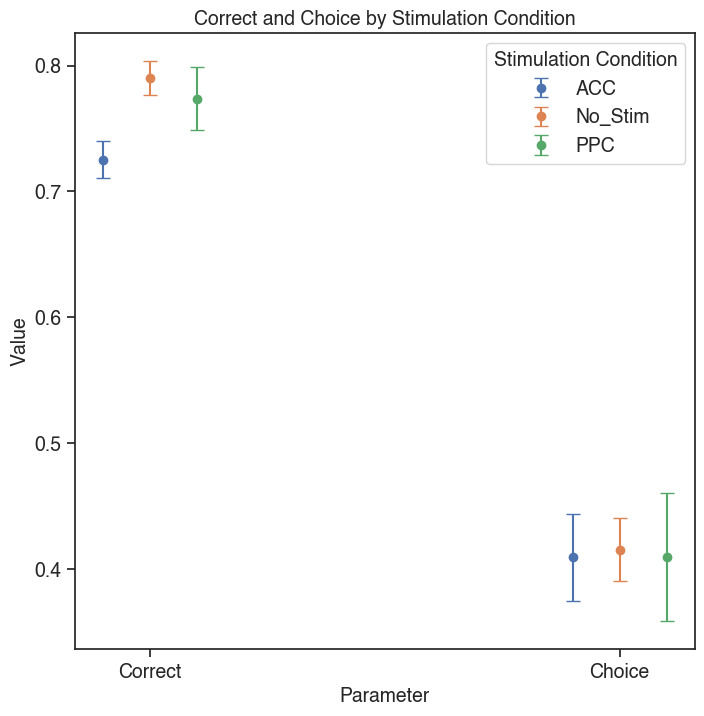

In [ ]:
# Calculating the mean and SEM for 'correct' and 'choice' parameters
correct_stats = perf_and_bias_df.groupby('Opto_Condition')['correct_mean'].agg(['mean', 'sem']).reset_index()
choice_stats = perf_and_bias_df.groupby('Opto_Condition')['choice_mean'].agg(['mean', 'sem']).reset_index()

# Prepare the data for plotting, similar to what we did before
plot_data_correct_choice = pd.DataFrame({
    'Condition': np.tile(correct_stats['Opto_Condition'], 2),  # Repeat condition names for 'correct' and 'choice'
    'Parameter': ['Correct'] * len(correct_stats) + ['Choice'] * len(choice_stats),
    'Mean': np.concatenate([correct_stats['mean'], choice_stats['mean']]),
    'SEM': np.concatenate([correct_stats['sem'], choice_stats['sem']])
})

# Define offsets for the x-axis positions
offsets = {'ACC': -0.1, 'No_Stim': 0.0, 'PPC': 0.1}

# Mapping of conditions to colors (palette defined previously)
conditions = plot_data_correct_choice['Condition'].unique()
palette = sns.color_palette('deep', len(conditions))
condition_palette = dict(zip(conditions, palette))

# Initialize the plot
plt.figure(figsize=(8, 8))

# Plotting each condition with its offset
for condition in conditions:
    # Filter data for the condition and create a copy to avoid SettingWithCopyWarning
    condition_data = plot_data_correct_choice[plot_data_correct_choice['Condition'] == condition].copy()
    # Apply offset to the x-axis position
    condition_data['x_pos'] = condition_data.apply(lambda row: ['Correct', 'Choice'].index(row['Parameter']) + offsets[row['Condition']], axis=1)
    
    # Plot each point with error bars
    plt.errorbar(x=condition_data['x_pos'], y=condition_data['Mean'], yerr=condition_data['SEM'],
                 fmt='o', label=condition, color=condition_palette[condition], capsize=5)

# Customize the x-axis
plt.xticks(ticks=[0, 1], labels=['Correct', 'Choice'])

# Adding plot title and labels
plt.title('Correct and Choice by Stimulation Condition')
plt.xlabel('Parameter')
plt.ylabel('Value')
plt.legend(title='Stimulation Condition')
# plt.grid(True)

# Show the plot
plt.show()


In [ ]:
p_ids = ['QP098', 'QP099']
psych_params_df = ut.gen_blockwise_psych_params(sub_df, p_ids)
# rename the "Block" column to "block" in the psych_params_df dataframe
psych_params_df = psych_params_df.rename(columns={'Block': 'block'})
# Identifying composite key columns
composite_keys = ['Participant_ID', 'block']  # Replace with the actual key column names
# Dropping duplicate rows in data_df based on composite keys
sub_df_unique = sub_df.drop_duplicates(subset=composite_keys)
# Columns from data_df to merge
columns_to_merge = ['Opto_On', 'Fiber', 'Mask', 'Zapit', 'Stimulation_Site', 'Opto_Condition']
# Merging
psych_params_df = psych_params_df.merge(sub_df_unique[composite_keys + columns_to_merge], 
                                        on=composite_keys, how='left')

In [ ]:
# remove rows where Block_Means_Std is greater than 2
psych_params_clean_df = psych_params_df[psych_params_df.Block_Means_Std < 1].reset_index(drop=True)
# only keep rows where Block_Means is greater that -0.8 and less than 0.8
psych_params_clean_df = psych_params_clean_df[(psych_params_clean_df.Block_Means > -0.8) & 
                                              (psych_params_clean_df.Block_Means < 0.8)].reset_index(drop=True)

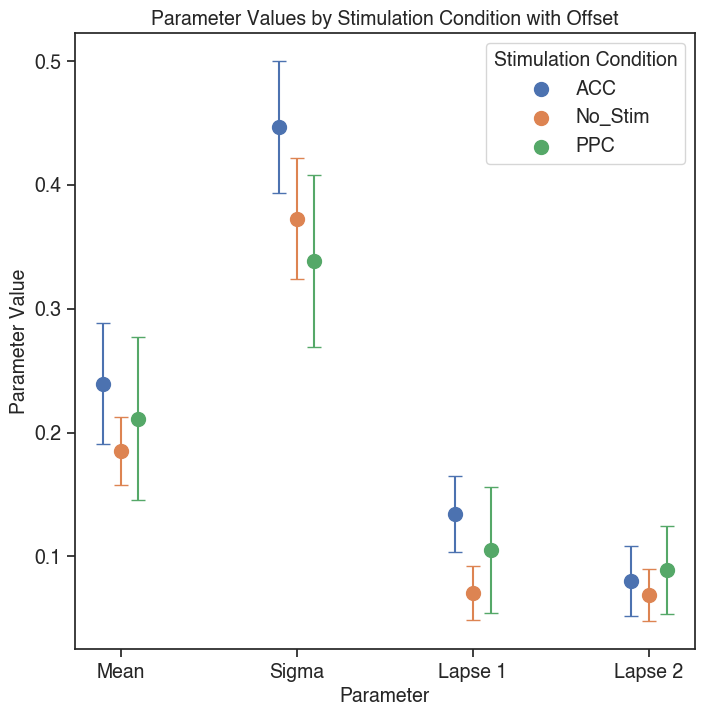

In [ ]:
# Grouping the data by 'Opto_Conditioon' and calculating the mean and SEM for the required columns
grouped_data = psych_params_clean_df.groupby('Opto_Condition').agg(['mean', 'sem'])
grouped_data.columns = ['_'.join(col).strip() for col in grouped_data.columns.values]

# Resetting index to get 'Opto_Conditioon' back as a column
grouped_data.reset_index(inplace=True)

# Melting the dataframe to get it into a long format suitable for seaborn's scatterplot
melted_data = pd.melt(grouped_data, 
                      id_vars='Opto_Condition', 
                      value_vars=['Block_Means_mean', 'Block_Slopes_mean', 'Block_Lapses_1_mean', 'Block_Lapses_2_mean', 
                                  'Block_Means_sem', 'Block_Slopes_sem', 'Block_Lapses_1_sem', 'Block_Lapses_2_sem'],
                      var_name='Parameter_Type', 
                      value_name='Value')

# Separating means and SEMs into two different DataFrames and avoiding chained assignments by creating copies
means_data = melted_data[melted_data['Parameter_Type'].str.contains('mean')].copy()
sems_data = melted_data[melted_data['Parameter_Type'].str.contains('sem')].copy()

# Renaming the 'Parameter_Type' to have a clean name for plotting
means_data['Parameter_Type'] = means_data['Parameter_Type'].str.replace('_mean', '')
sems_data['Parameter_Type'] = sems_data['Parameter_Type'].str.replace('_sem', '')

# Define the offset for each condition
offset_dict = {
    'ACC': -0.1, 
    'No_Stim': 0.0, 
    'PPC': 0.1
}

# Merge the means and SEMs for plotting
plot_data = pd.merge(means_data, sems_data, on=['Opto_Condition', 'Parameter_Type'])
plot_data.rename(columns={'Value_x': 'Mean', 'Value_y': 'SEM'}, inplace=True)

# Applying the offsets without creating a new column to avoid the warning
plt.figure(figsize=(8, 8))
unique_conditions = plot_data['Opto_Condition'].unique()
palette = sns.color_palette('deep', len(unique_conditions))
condition_palette = dict(zip(unique_conditions, palette))

# Get unique parameters for setting x-ticks
unique_params = plot_data['Parameter_Type'].unique()

# Plotting each condition separately to apply the offset
for condition in unique_conditions:
    subset = plot_data[plot_data['Opto_Condition'] == condition]
    # Convert x positions to numeric values, adding the offset
    x_numeric = np.array([unique_params.tolist().index(param) for param in subset['Parameter_Type']]) + offset_dict[condition]
    plt.scatter(x_numeric, subset['Mean'], color=condition_palette[condition], label=condition, s=100)
    plt.errorbar(x_numeric, subset['Mean'], yerr=subset['SEM'], fmt='none', capsize=5, color=condition_palette[condition])

# Set the x-axis labels manually
plt.xticks(ticks=[0, 1, 2, 3], labels=['Mean', 'Sigma', 'Lapse 1', 'Lapse 2'])

plt.title('Parameter Values by Stimulation Condition with Offset')
plt.ylabel('Parameter Value')
plt.xlabel('Parameter')
plt.legend(title='Stimulation Condition')
# plt.grid(True)
plt.show()


Opto_Condition  block_mean  block_sem  Block_Means_mean  Block_Means_sem  \
0            ACC  117.090909   1.534183          0.239403         0.048964   
1        No_Stim  122.000000   1.471960          0.185345         0.027283   
2            PPC  125.000000   2.380476          0.211340         0.066016   

   Block_Slopes_mean  Block_Slopes_sem  Block_Lapses_1_mean  \
0           0.446527          0.053303             0.133943   
1           0.372851          0.048874             0.070285   
2           0.338856          0.069352             0.105533   

   Block_Lapses_1_sem  Block_Lapses_2_mean  ...  Block_Lapses_2_Std_mean  \
0            0.030668             0.080505  ...                 0.145937   
1            0.021768             0.068812  ...                 0.098357   
2            0.050762             0.089112  ...                 0.079192   

   Block_Lapses_2_Std_sem  Opto_On_mean  Opto_On_sem  Fiber_mean  Fiber_sem  \
0                0.042953           1.0          0.0    0.090909   0.090909   
1                0.025858           0.0          0.0    0.000000   0.000000   
2                0.037530           1.0          0.0    0.000000   0.000000   

   Mask_mean  Mask_sem  Zapit_mean  Zapit_sem  
0   0.090909  0.090909         0.0        0.0  
1   0.000000  0.000000         0.0        0.0  
2   0.000000  0.000000         0.0        0.0  

[3 rows x 27 columns]

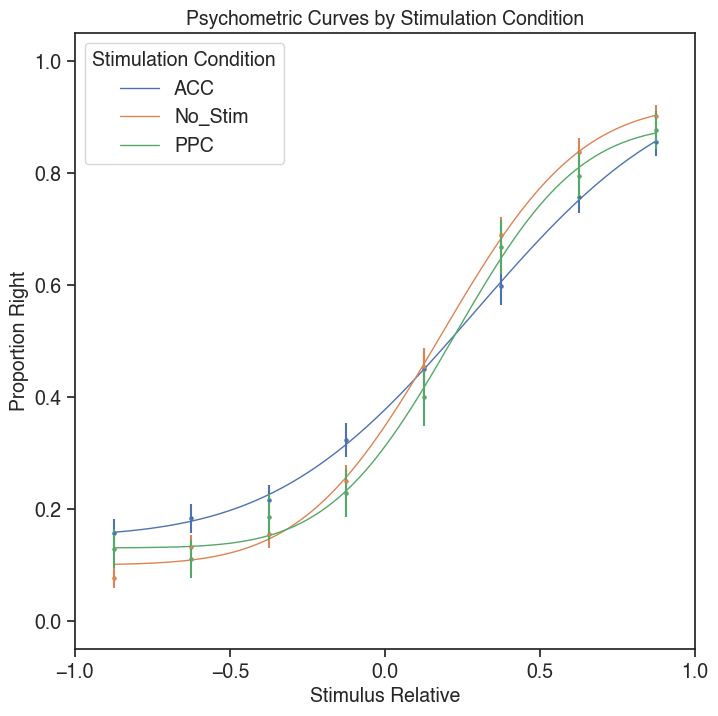

In [ ]:
# plot psychometric curves for all three conditions

fig, ax = plt.subplots(figsize=(8, 8))

for condition in sub_df['Opto_Condition'].unique():
    condition_df = sub_df[sub_df['Opto_Condition'] == condition]
    popt = ut.psycho_fit(condition_df)[0]
    ut.psycho_plot(condition_df, popt, label=condition, color=condition_palette[condition], ax=ax)

ax.set_title('Psychometric Curves by Stimulation Condition')
ax.set_xlabel('Stimulus Relative')
ax.set_ylabel('Proportion Right')
ax.legend(title='Stimulation Condition')
# ax.grid(True)
plt.show()
